# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [353]:
import tensorflow as tf
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1"

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [354]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data('mnist.npz')
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

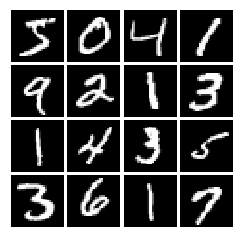

In [355]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [356]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return(tf.maximum(x,alpha*x))


Test your leaky ReLU implementation. You should get errors < 1e-10

In [357]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [358]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    
    
    return(tf.random_uniform(shape=(batch_size,dim),minval=-1.0,maxval=1.0,dtype=tf.float32))


Make sure noise is the correct shape and type:

In [359]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [360]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):

        nlayer = tf.layers.dense(inputs=x,units=256,activation=None)
        nlayer = leaky_relu(nlayer,alpha=0.01)
        nlayers=tf.layers.dense(inputs=nlayer,units=256,activation=None)
        nlayer =leaky_relu(nlayer,alpha=0.01)
        logits =tf.layers.dense(inputs=nlayer,units=1,activation=None)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [361]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [362]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        img = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        img = tf.layers.dense(inputs=img,units=1024,activation=tf.nn.relu)
        img = tf.layers.dense(inputs=img,units=784,activation=tf.nn.tanh)
        return img

Test to make sure the number of parameters in the generator is correct:

In [363]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [364]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    
    HINT: for the discriminator loss, you'll want to do the averaging separately for
    its two components, and then add them together (instead of averaging once at the very end).
    """
    # TODO: compute D_loss and G_loss
       
    G_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    D_loss_real =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)))
    D_loss_fake =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake)))
    D_loss = D_loss_real + D_loss_fake

    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [365]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [366]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5)
    G_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [367]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 16
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [385]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=2, print_every=1, batch_size=16, num_epoch=100):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    for epoch in range(num_epoch):
        #print("new epoch",epoch)
        # every show often, show a sample result
        if epoch % show_every == 0:
            
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
            
        minibatchid=0
        for (minibatch, minbatch_y) in mnist:
            # run a batch of data through the network
            #print("one batch",minibatchid)
            minibatchid+=1
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            av_d_loss = tf.reduce_mean(D_loss_curr)
            av_g_loss = tf.reduce_mean(G_loss_curr)
            #print('Epoch:{},D: {:.4}, G:{:.4}'.format(epoch,av_d_loss,av_g_loss))
            print("Epoch:",epoch)
            
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

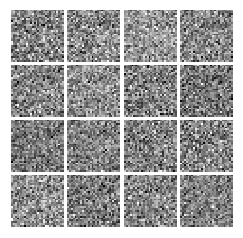


Epoch: 0
Epoch: 1


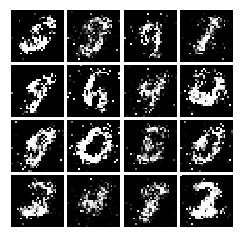


Epoch: 2
Epoch: 3


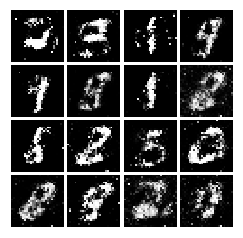


Epoch: 4
Epoch: 5


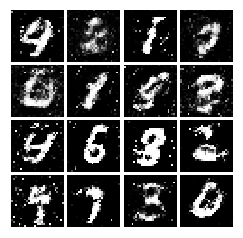


Epoch: 6
Epoch: 7


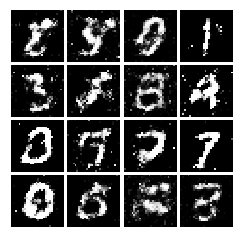


Epoch: 8
Epoch: 9


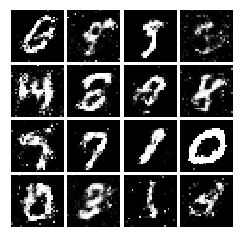


Epoch: 10
Epoch: 11


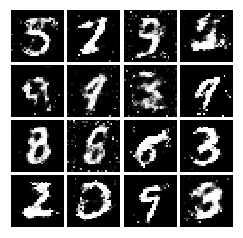


Epoch: 12
Epoch: 13


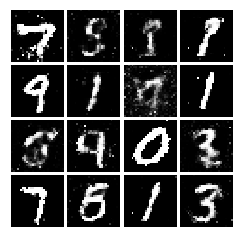


Epoch: 14
Epoch: 15


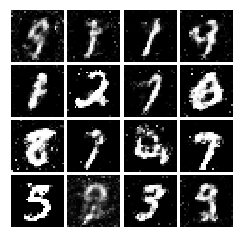


Epoch: 16
Epoch: 17


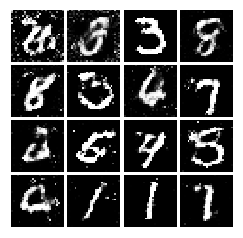


Epoch: 18
Epoch: 19


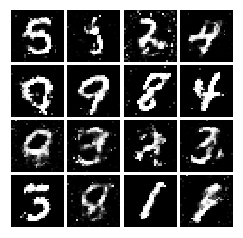


Epoch: 20
Epoch: 21


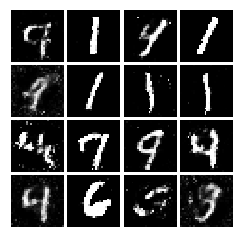


Epoch: 22
Epoch: 23


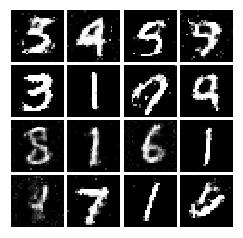


Epoch: 24
Epoch: 25


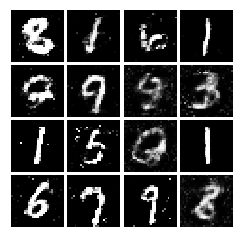


Epoch: 26
Epoch: 27


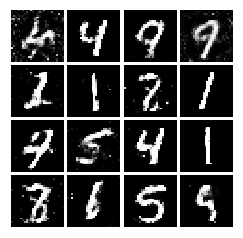


Epoch: 28
Epoch: 29


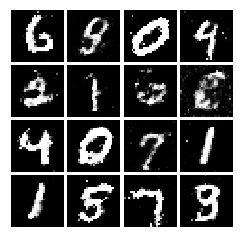


Epoch: 30
Epoch: 31


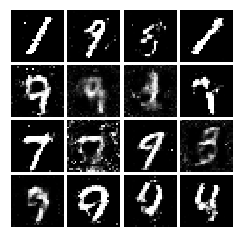


Epoch: 32
Epoch: 33


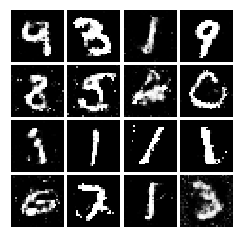


Epoch: 34
Epoch: 35


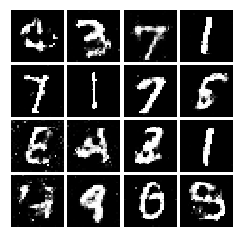


Epoch: 36
Epoch: 37


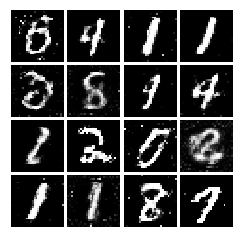


Epoch: 38
Epoch: 39


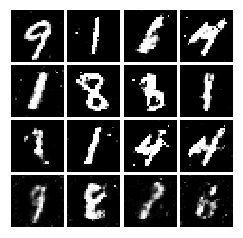


Epoch: 40
Epoch: 41


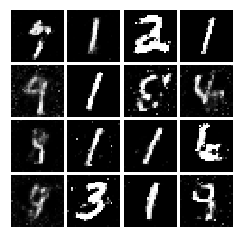


Epoch: 42
Epoch: 43


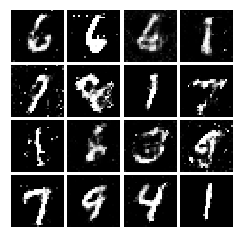


Epoch: 44
Epoch: 45


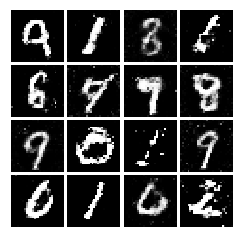


Epoch: 46
Epoch: 47


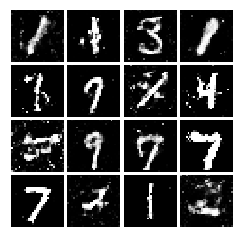


Epoch: 48
Epoch: 49


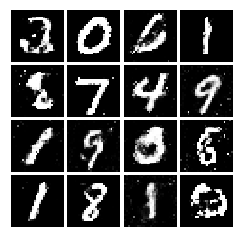


Epoch: 50
Epoch: 51


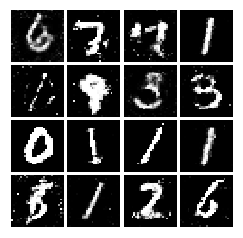


Epoch: 52
Epoch: 53


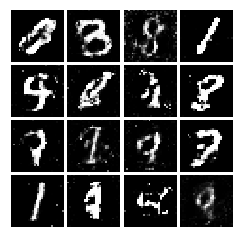


Epoch: 54
Epoch: 55


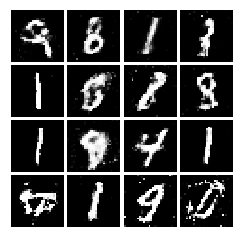


Epoch: 56
Epoch: 57


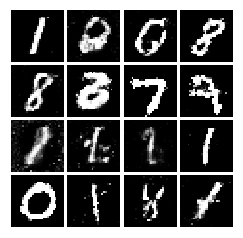


Epoch: 58
Epoch: 59


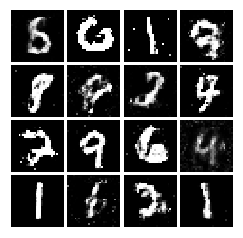


Epoch: 60
Epoch: 61


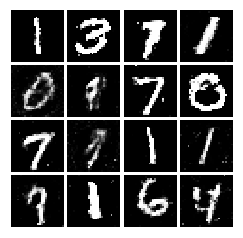


Epoch: 62
Epoch: 63


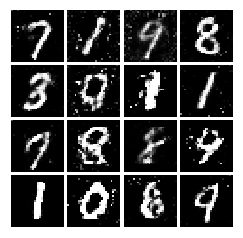


Epoch: 64
Epoch: 65


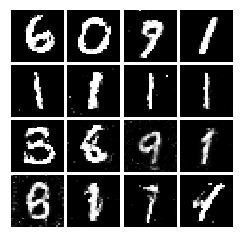


Epoch: 66
Epoch: 67


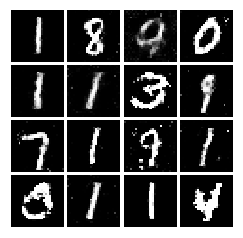


Epoch: 68
Epoch: 69


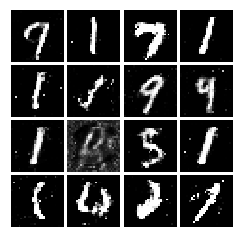


Epoch: 70
Epoch: 71


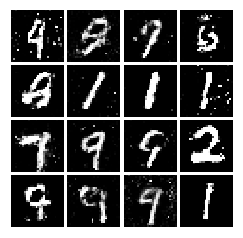


Epoch: 72
Epoch: 73


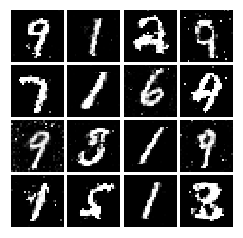


Epoch: 74
Epoch: 75


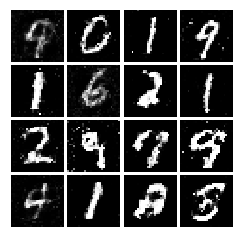


Epoch: 76
Epoch: 77


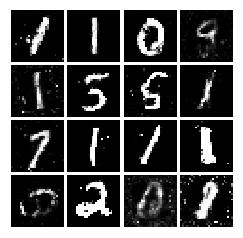


Epoch: 78
Epoch: 79


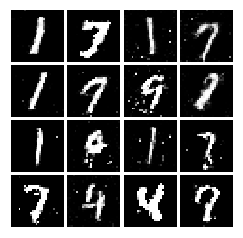


Epoch: 80
Epoch: 81


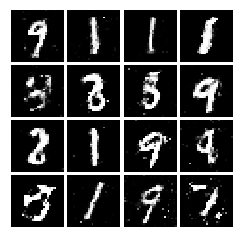


Epoch: 82
Epoch: 83


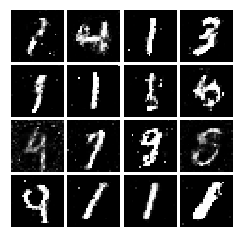


Epoch: 84
Epoch: 85


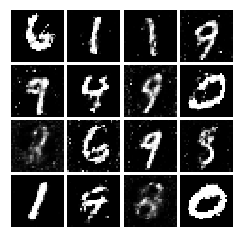


Epoch: 86
Epoch: 87


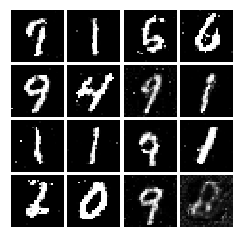


Epoch: 88
Epoch: 89


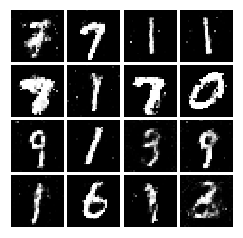


Epoch: 90
Epoch: 91


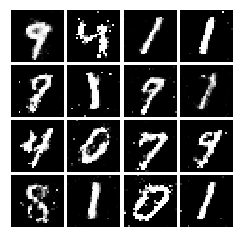


Epoch: 92
Epoch: 93


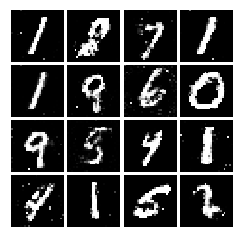


Epoch: 94
Epoch: 95


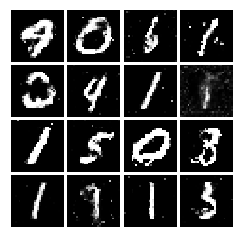


Epoch: 96
Epoch: 97


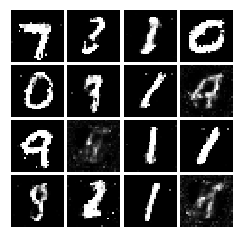


Epoch: 98
Epoch: 99


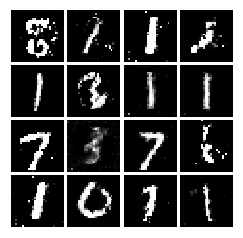


Epoch: 100
Epoch: 101


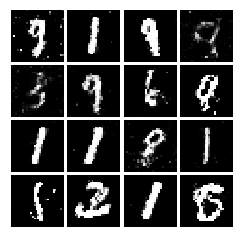


Epoch: 102
Epoch: 103


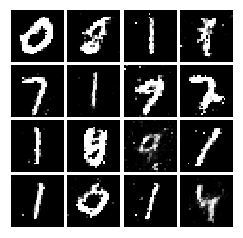


Epoch: 104
Epoch: 105


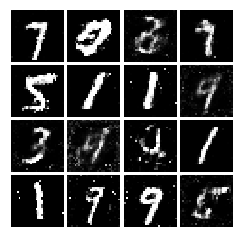


Epoch: 106
Epoch: 107


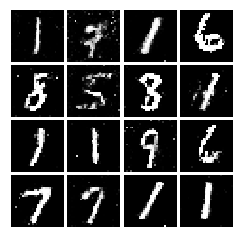


Epoch: 108
Epoch: 109


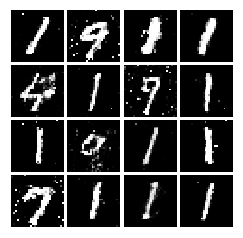


Epoch: 110
Epoch: 111


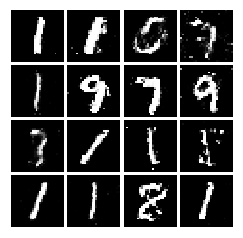


Epoch: 112
Epoch: 113


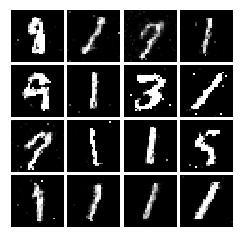


Epoch: 114
Epoch: 115


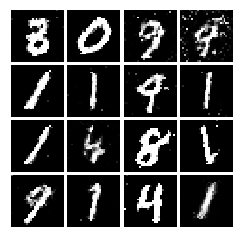


Epoch: 116
Epoch: 117


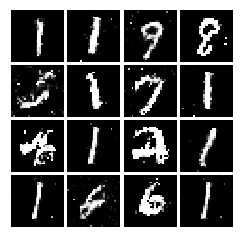


Epoch: 118
Epoch: 119


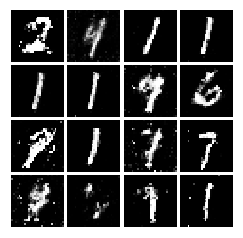


Epoch: 120
Epoch: 121


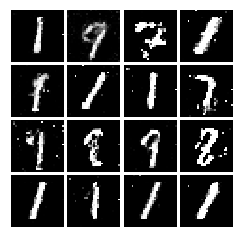


Epoch: 122
Epoch: 123


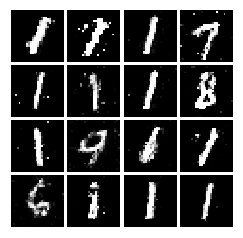


Epoch: 124
Epoch: 125


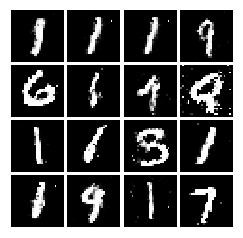


Epoch: 126
Epoch: 127


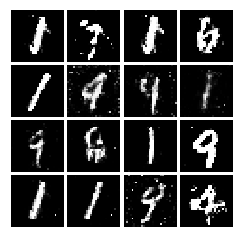


Epoch: 128
Epoch: 129


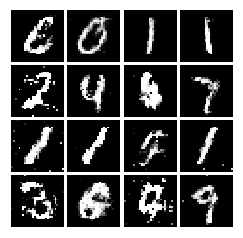


Epoch: 130
Epoch: 131


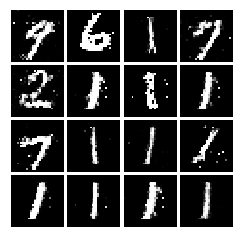


Epoch: 132
Epoch: 133


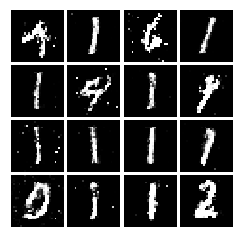


Epoch: 134
Epoch: 135


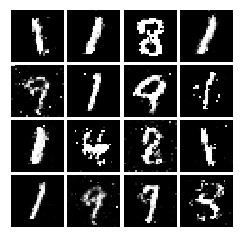


Epoch: 136
Epoch: 137


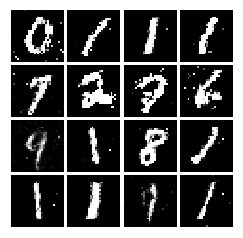


Epoch: 138
Epoch: 139


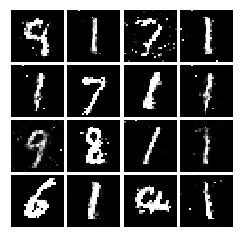


Epoch: 140
Epoch: 141


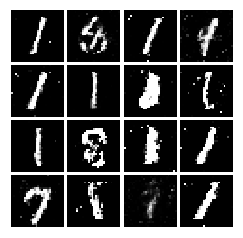


Epoch: 142
Epoch: 143


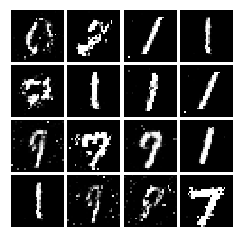


Epoch: 144
Epoch: 145


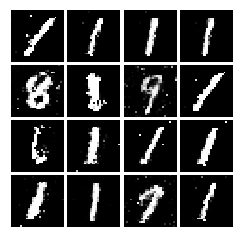


Epoch: 146
Epoch: 147


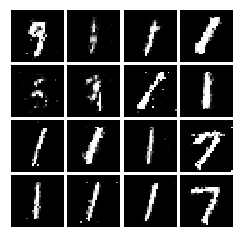


Epoch: 148
Epoch: 149


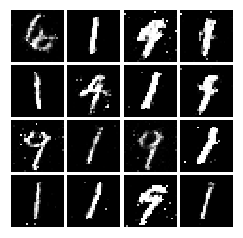


Epoch: 150
Epoch: 151


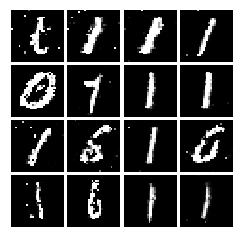


Epoch: 152
Epoch: 153


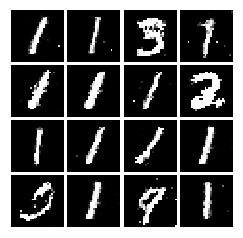


Epoch: 154
Epoch: 155


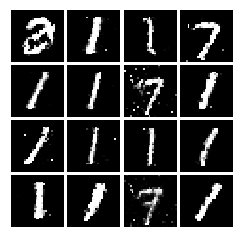


Epoch: 156
Epoch: 157


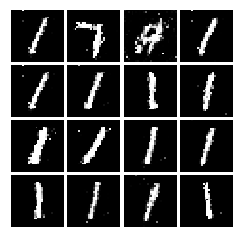


Epoch: 158
Epoch: 159


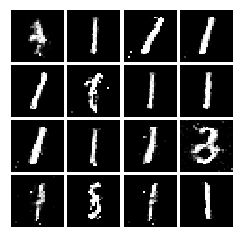


Epoch: 160
Epoch: 161


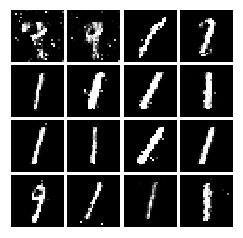


Epoch: 162
Epoch: 163


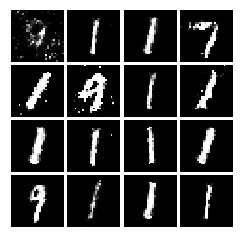


Epoch: 164
Epoch: 165


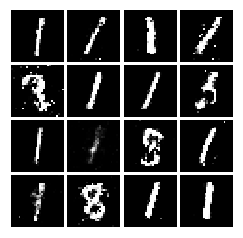


Epoch: 166
Epoch: 167


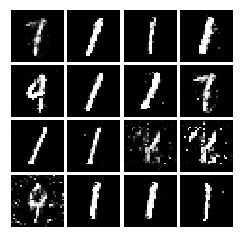


Epoch: 168
Epoch: 169


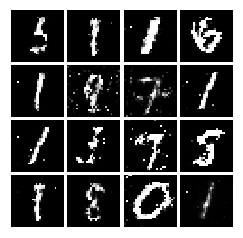


Epoch: 170
Epoch: 171


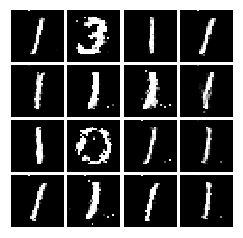


Epoch: 172
Epoch: 173


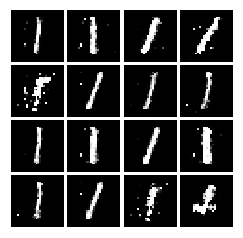


Epoch: 174
Epoch: 175


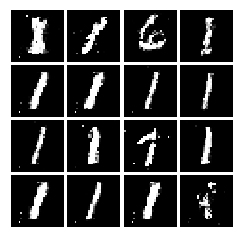


Epoch: 176
Epoch: 177


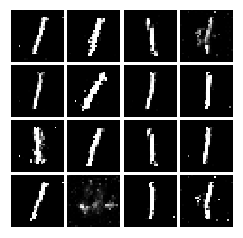


Epoch: 178
Epoch: 179


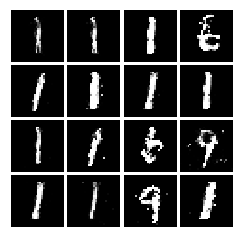


Epoch: 180
Epoch: 181


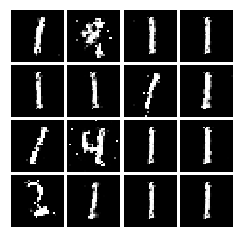


Epoch: 182
Epoch: 183


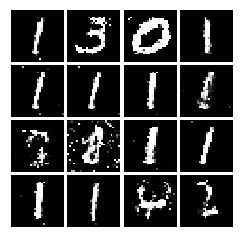


Epoch: 184
Epoch: 185


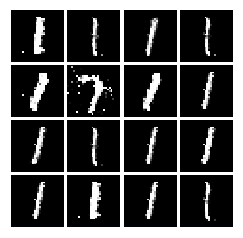


Epoch: 186
Epoch: 187


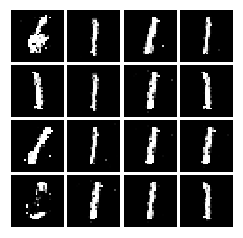


Epoch: 188
Epoch: 189


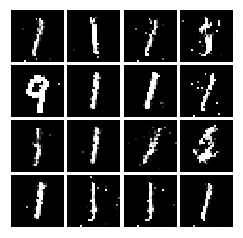


Epoch: 190
Epoch: 191


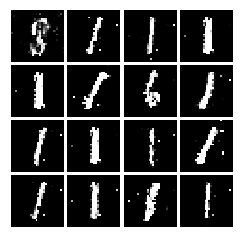


Epoch: 192
Epoch: 193


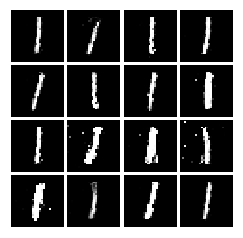


Epoch: 194
Epoch: 195


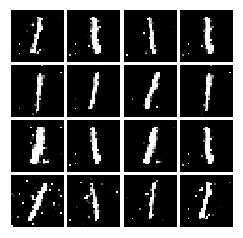


Epoch: 196
Epoch: 197


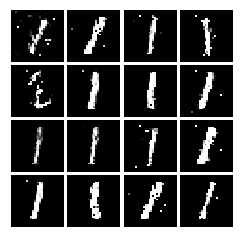


Epoch: 198
Epoch: 199


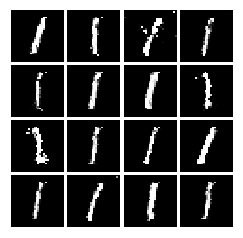


Epoch: 200
Epoch: 201


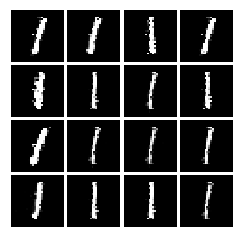


Epoch: 202
Epoch: 203


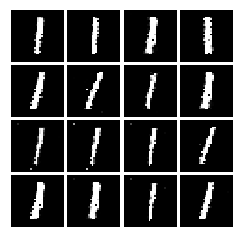


Epoch: 204
Epoch: 205


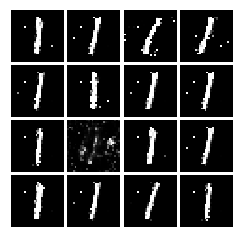


Epoch: 206
Epoch: 207


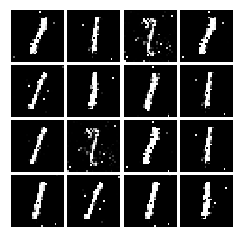


Epoch: 208
Epoch: 209


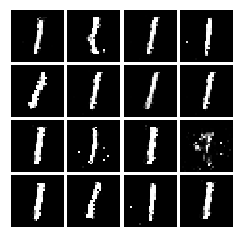


Epoch: 210
Epoch: 211


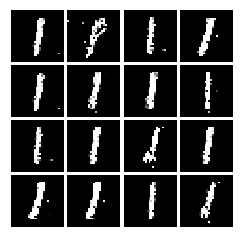


Epoch: 212
Epoch: 213


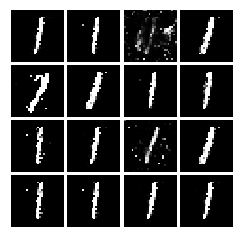


Epoch: 214
Epoch: 215


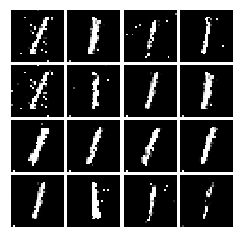


Epoch: 216
Epoch: 217


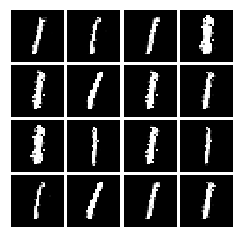


Epoch: 218
Epoch: 219


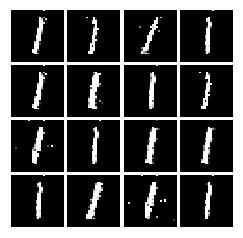


Epoch: 220
Epoch: 221


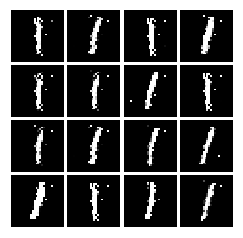


Epoch: 222
Epoch: 223


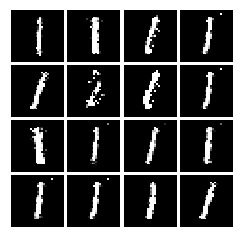


Epoch: 224
Epoch: 225


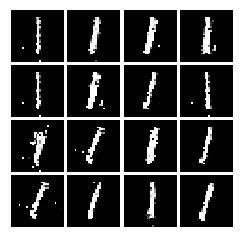


Epoch: 226
Epoch: 227


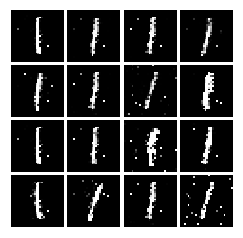


Epoch: 228
Epoch: 229


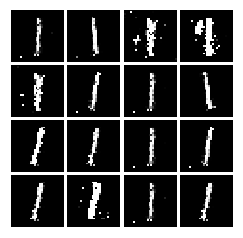


Epoch: 230
Epoch: 231


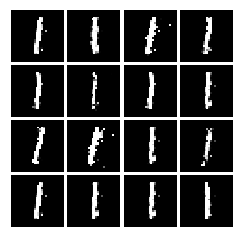


Epoch: 232
Epoch: 233


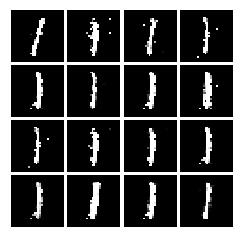


Epoch: 234
Epoch: 235


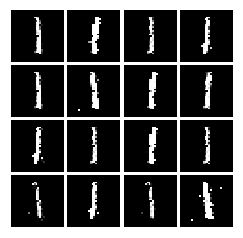


Epoch: 236
Epoch: 237


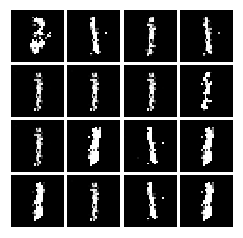


Epoch: 238
Epoch: 239


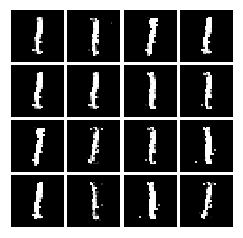


Epoch: 240
Epoch: 241


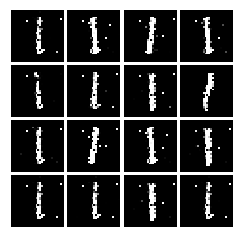


Epoch: 242
Epoch: 243


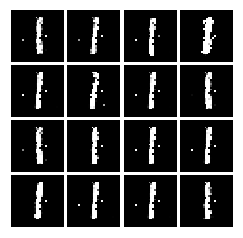


Epoch: 244
Epoch: 245


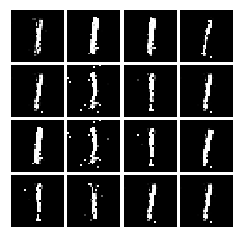


Epoch: 246
Epoch: 247


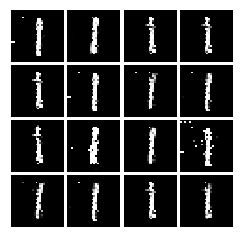


Epoch: 248
Epoch: 249


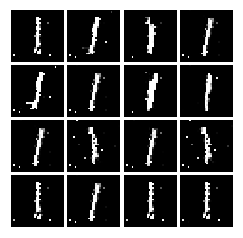


Epoch: 250
Epoch: 251


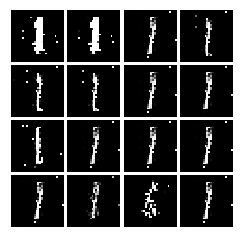


Epoch: 252
Epoch: 253


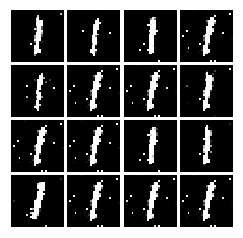


Epoch: 254
Epoch: 255


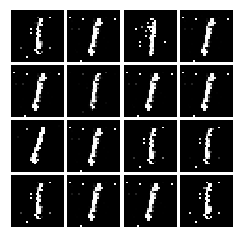


Epoch: 256
Epoch: 257


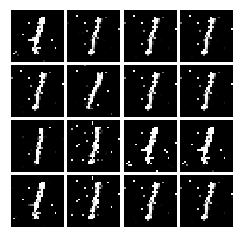


Epoch: 258
Epoch: 259


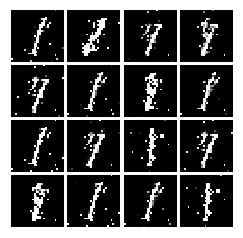


Epoch: 260
Epoch: 261


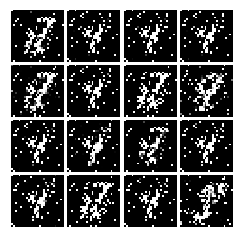


Epoch: 262
Epoch: 263


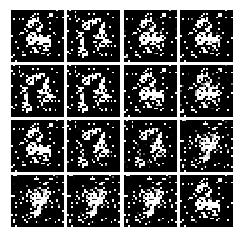


Epoch: 264
Epoch: 265


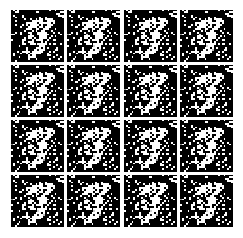


Epoch: 266
Epoch: 267


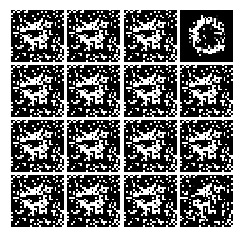


Epoch: 268
Epoch: 269


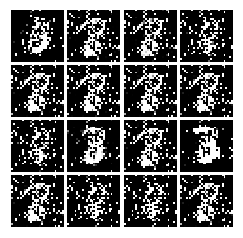


Epoch: 270
Epoch: 271


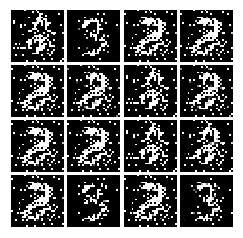


Epoch: 272
Epoch: 273


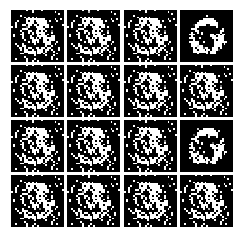


Epoch: 274
Epoch: 275


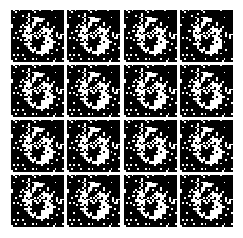


Epoch: 276
Epoch: 277


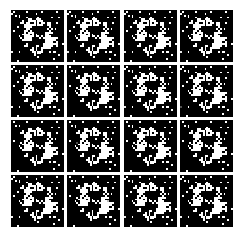


Epoch: 278
Epoch: 279


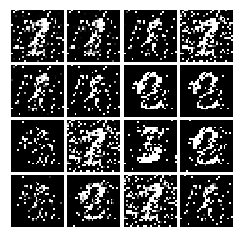


Epoch: 280
Epoch: 281


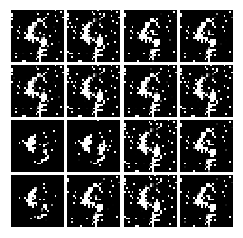


Epoch: 282
Epoch: 283


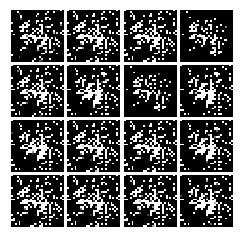


Epoch: 284
Epoch: 285


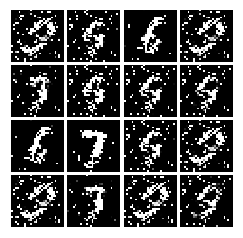


Epoch: 286
Epoch: 287


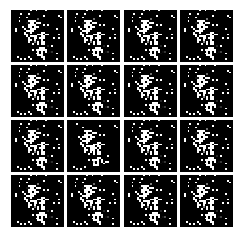


Epoch: 288
Epoch: 289


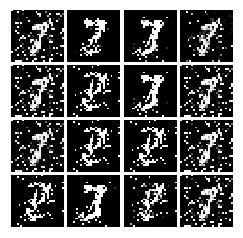


Epoch: 290
Epoch: 291


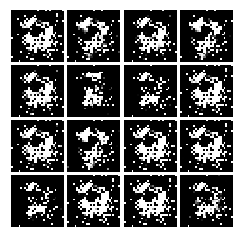


Epoch: 292
Epoch: 293


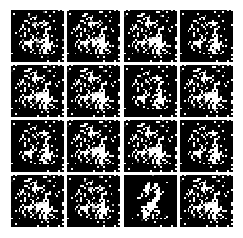


Epoch: 294
Epoch: 295


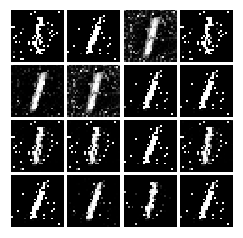


Epoch: 296
Epoch: 297


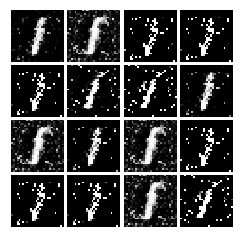


Epoch: 298
Epoch: 299


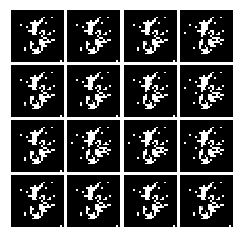


Epoch: 300
Epoch: 301


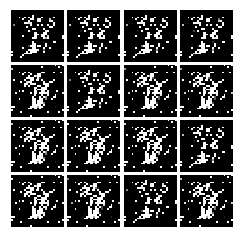


Epoch: 302
Epoch: 303


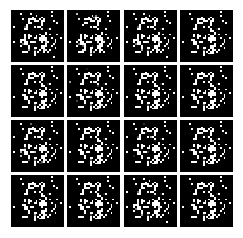


Epoch: 304
Epoch: 305


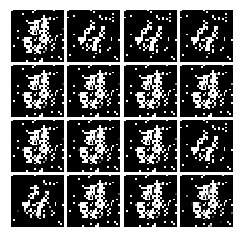


Epoch: 306
Epoch: 307


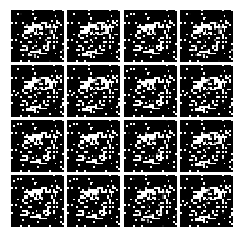


Epoch: 308
Epoch: 309


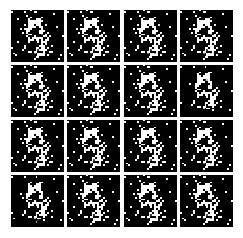


Epoch: 310
Epoch: 311


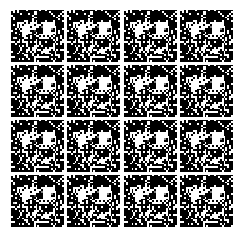


Epoch: 312
Epoch: 313


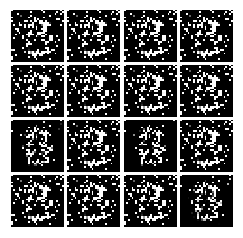


Epoch: 314
Epoch: 315


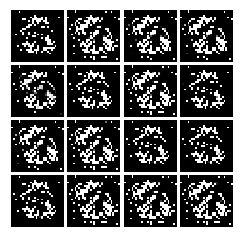


Epoch: 316
Epoch: 317


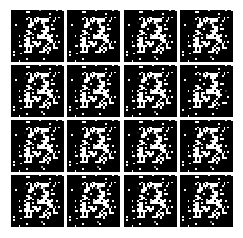


Epoch: 318
Epoch: 319


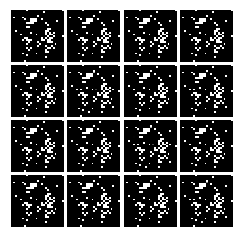


Epoch: 320
Epoch: 321


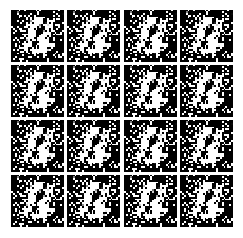


Epoch: 322
Epoch: 323


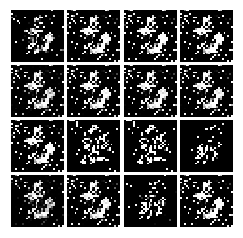


Epoch: 324
Epoch: 325


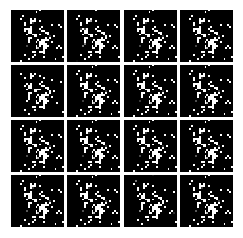


Epoch: 326
Epoch: 327


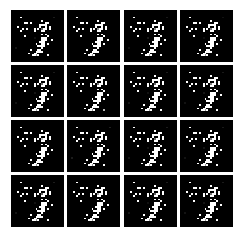


Epoch: 328
Epoch: 329


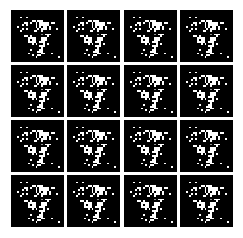


Epoch: 330
Epoch: 331


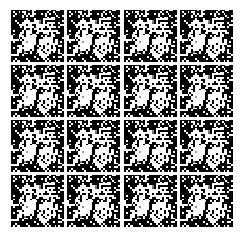


Epoch: 332
Epoch: 333


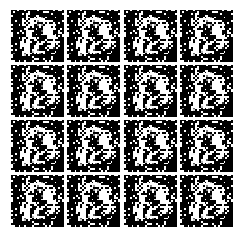


Epoch: 334
Epoch: 335


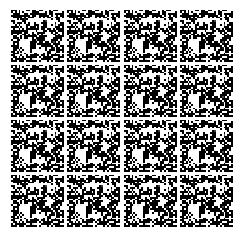


Epoch: 336
Epoch: 337


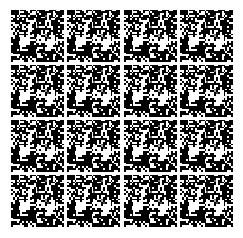


Epoch: 338
Epoch: 339


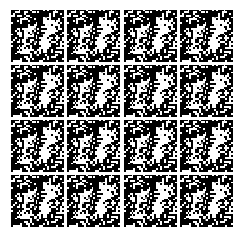


Epoch: 340
Epoch: 341


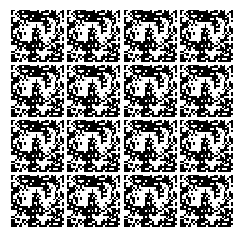


Epoch: 342
Epoch: 343


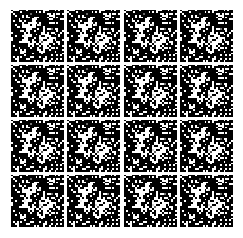


Epoch: 344
Epoch: 345


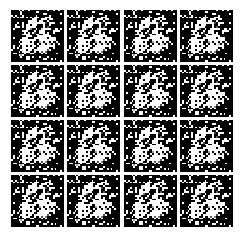


Epoch: 346
Epoch: 347


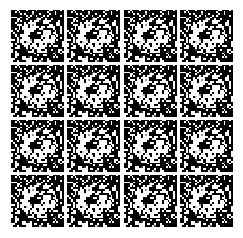


Epoch: 348
Epoch: 349


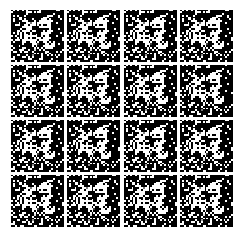


Epoch: 350
Epoch: 351


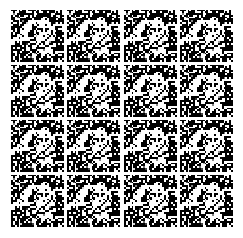


Epoch: 352
Epoch: 353


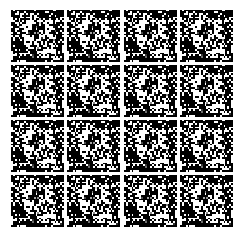


Epoch: 354
Epoch: 355


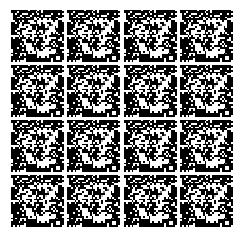


Epoch: 356
Epoch: 357


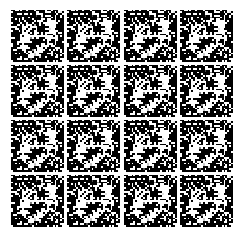


Epoch: 358
Epoch: 359


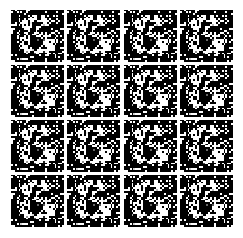


Epoch: 360
Epoch: 361


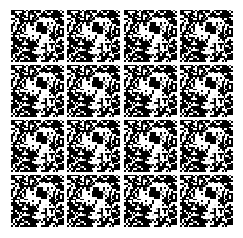


Epoch: 362
Epoch: 363


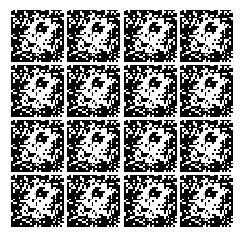


Epoch: 364
Epoch: 365


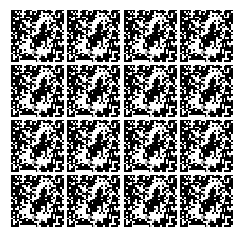


Epoch: 366
Epoch: 367


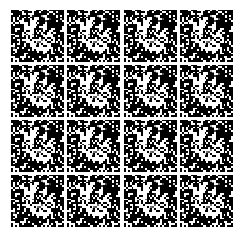


Epoch: 368
Epoch: 369


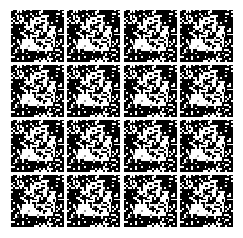


Epoch: 370
Epoch: 371


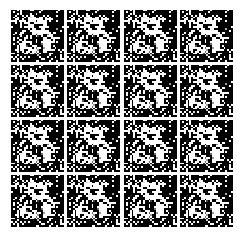


Epoch: 372
Epoch: 373


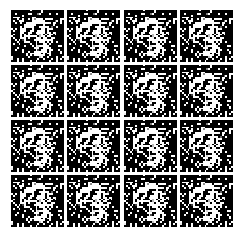


Epoch: 374
Epoch: 375


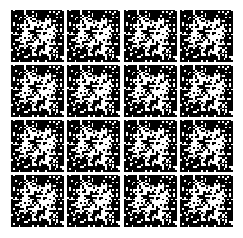


Epoch: 376
Epoch: 377


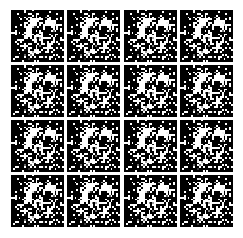


Epoch: 378
Epoch: 379


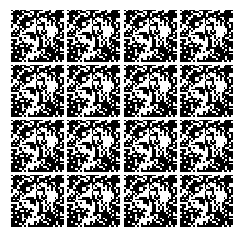


Epoch: 380
Epoch: 381


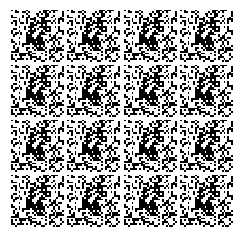


Epoch: 382
Epoch: 383


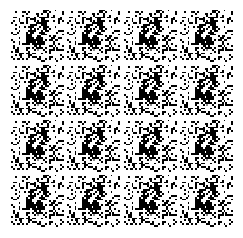


Epoch: 384
Epoch: 385


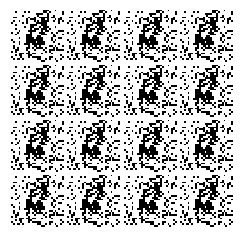


Epoch: 386
Epoch: 387


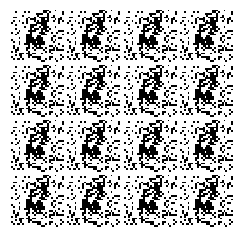


Epoch: 388
Epoch: 389


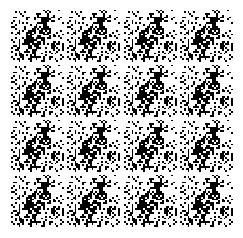


Epoch: 390
Epoch: 391


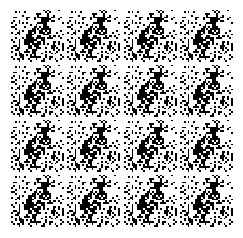


Epoch: 392
Epoch: 393


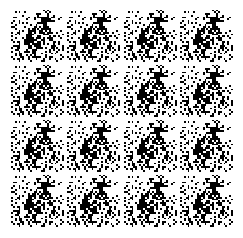


Epoch: 394
Epoch: 395


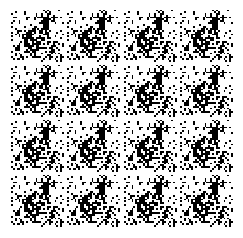


Epoch: 396
Epoch: 397


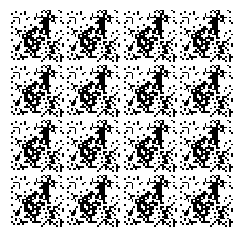


Epoch: 398
Epoch: 399


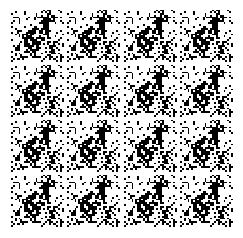


Epoch: 400
Epoch: 401


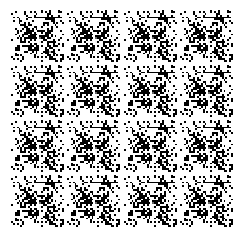


Epoch: 402
Epoch: 403


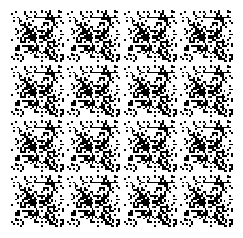


Epoch: 404
Epoch: 405


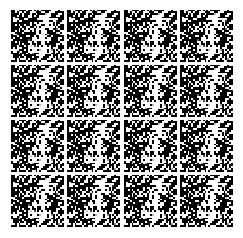


Epoch: 406
Epoch: 407


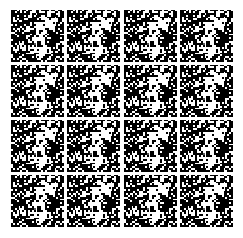


Epoch: 408
Epoch: 409


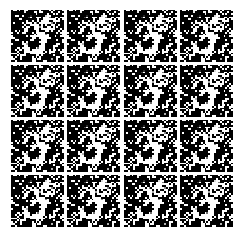


Epoch: 410
Epoch: 411


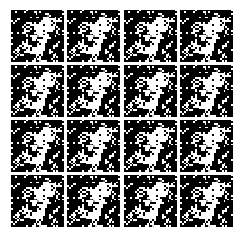


Epoch: 412
Epoch: 413


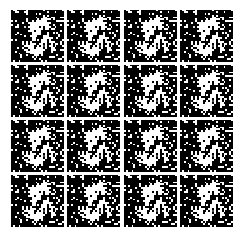


Epoch: 414
Epoch: 415


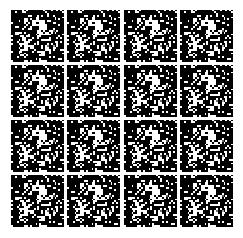


Epoch: 416
Epoch: 417


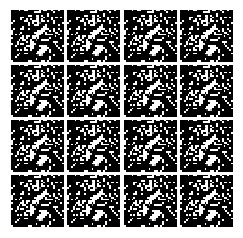


Epoch: 418
Epoch: 419


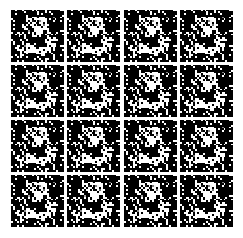


Epoch: 420
Epoch: 421


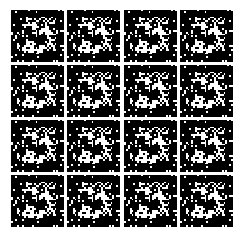


Epoch: 422
Epoch: 423


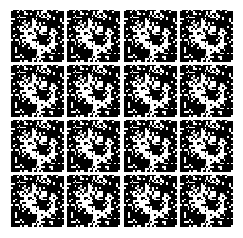


Epoch: 424
Epoch: 425


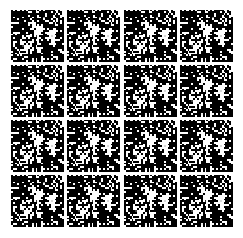


Epoch: 426
Epoch: 427


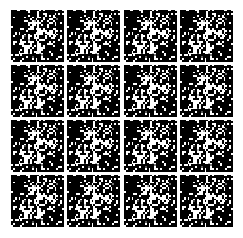


Epoch: 428
Epoch: 429


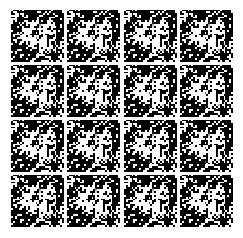


Epoch: 430
Epoch: 431


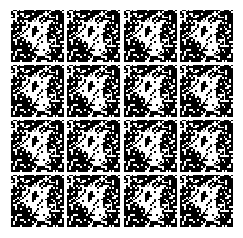


Epoch: 432
Epoch: 433


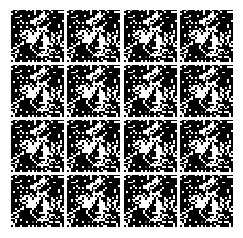


Epoch: 434
Epoch: 435


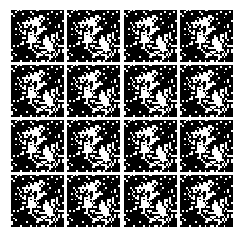


Epoch: 436
Epoch: 437


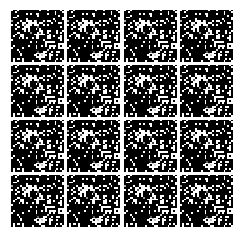


Epoch: 438
Epoch: 439


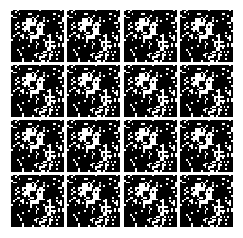


Epoch: 440
Epoch: 441


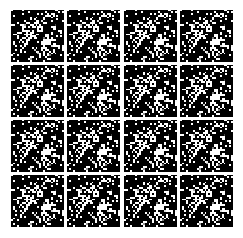


Epoch: 442
Epoch: 443


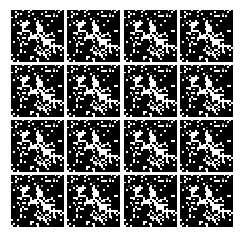


Epoch: 444
Epoch: 445


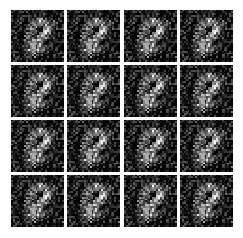


Epoch: 446
Epoch: 447


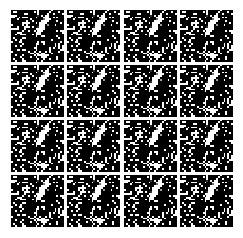


Epoch: 448
Epoch: 449


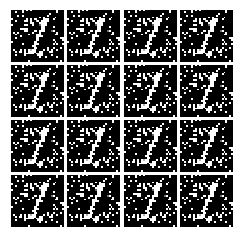


Epoch: 450
Epoch: 451


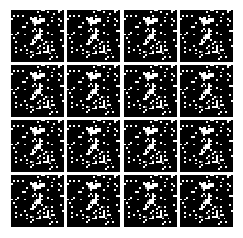


Epoch: 452
Epoch: 453


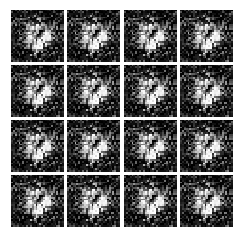


Epoch: 454
Epoch: 455


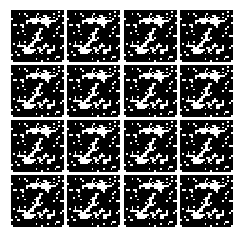


Epoch: 456
Epoch: 457


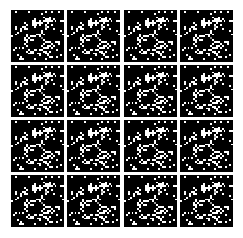


Epoch: 458
Epoch: 459


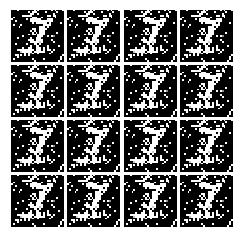


Epoch: 460
Epoch: 461


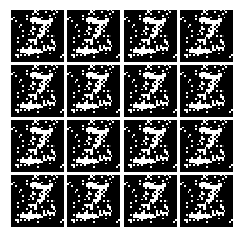


Epoch: 462
Epoch: 463


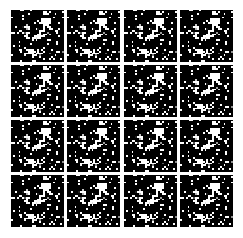


Epoch: 464
Epoch: 465


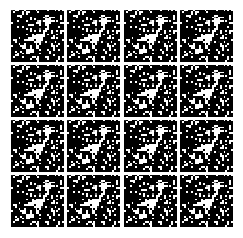


Epoch: 466
Epoch: 467


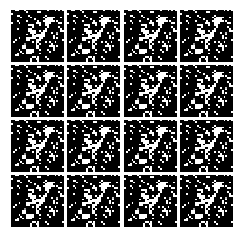


Epoch: 468
Epoch: 469


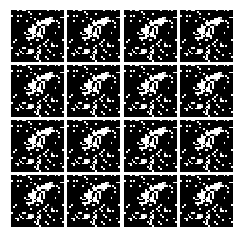


Epoch: 470
Epoch: 471


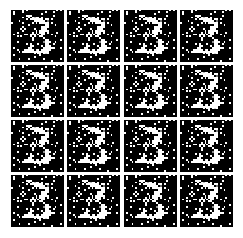


Epoch: 472
Epoch: 473


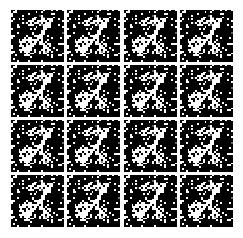


Epoch: 474
Epoch: 475


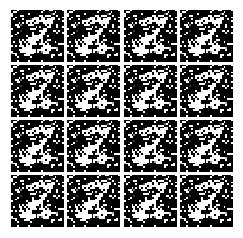


Epoch: 476
Epoch: 477


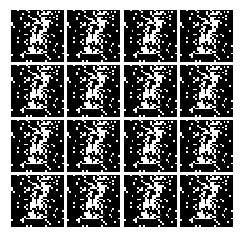


Epoch: 478
Epoch: 479


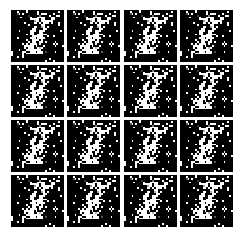


Epoch: 480
Epoch: 481


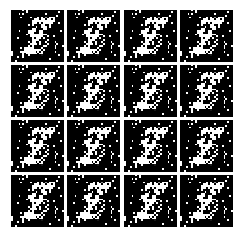


Epoch: 482
Epoch: 483


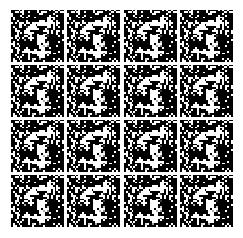


Epoch: 484
Epoch: 485


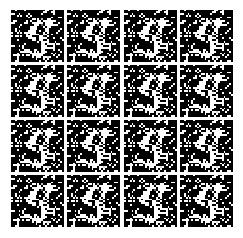


Epoch: 486
Epoch: 487


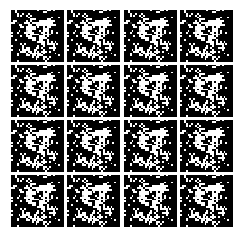


Epoch: 488
Epoch: 489


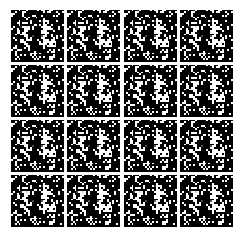


Epoch: 490
Epoch: 491


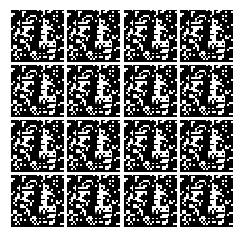


Epoch: 492
Epoch: 493


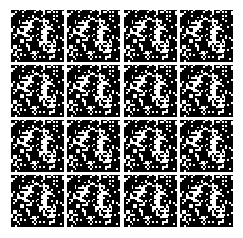


Epoch: 494
Epoch: 495


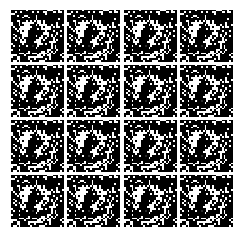


Epoch: 496
Epoch: 497


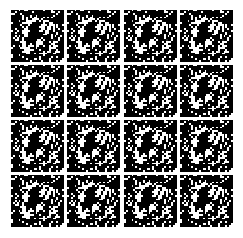


Epoch: 498
Epoch: 499


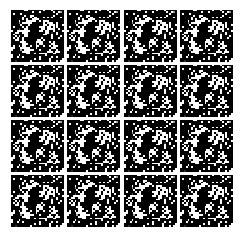


Epoch: 500
Epoch: 501


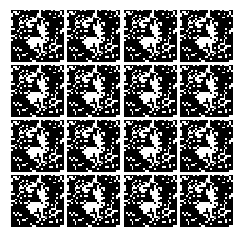


Epoch: 502
Epoch: 503


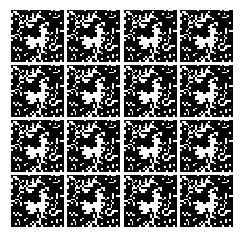


Epoch: 504
Epoch: 505


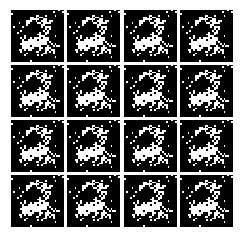


Epoch: 506
Epoch: 507


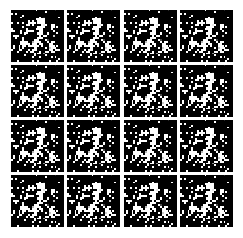


Epoch: 508
Epoch: 509


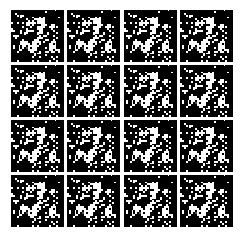


Epoch: 510
Epoch: 511


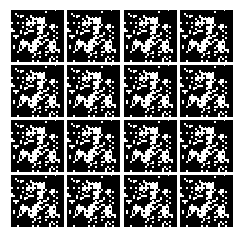


Epoch: 512
Epoch: 513


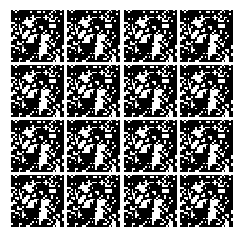


Epoch: 514
Epoch: 515


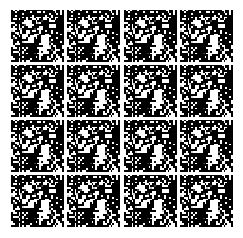


Epoch: 516
Epoch: 517


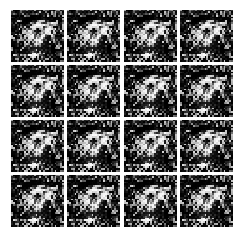


Epoch: 518
Epoch: 519


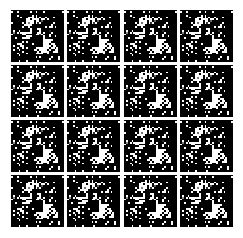


Epoch: 520
Epoch: 521


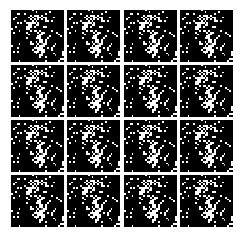


Epoch: 522
Epoch: 523


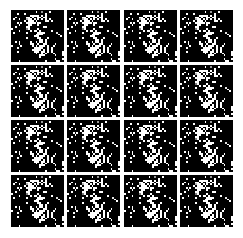


Epoch: 524
Epoch: 525


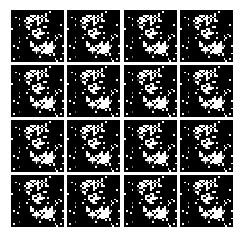


Epoch: 526
Epoch: 527


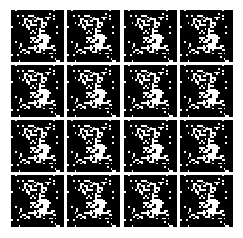


Epoch: 528
Epoch: 529


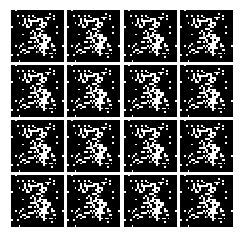


Epoch: 530
Epoch: 531


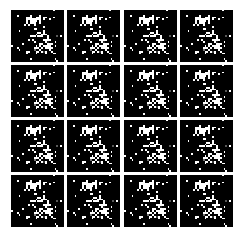


Epoch: 532
Epoch: 533


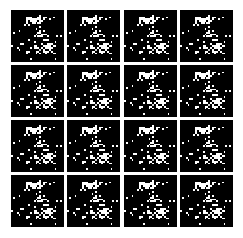


Epoch: 534
Epoch: 535


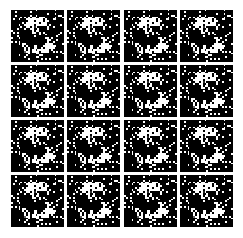


Epoch: 536
Epoch: 537


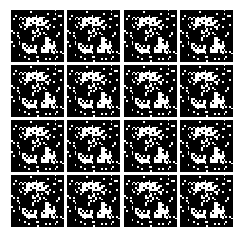


Epoch: 538
Epoch: 539


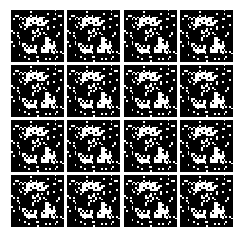


Epoch: 540
Epoch: 541


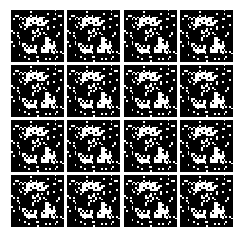


Epoch: 542
Epoch: 543


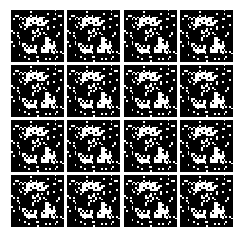


Epoch: 544
Epoch: 545


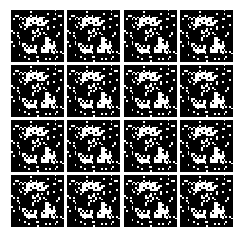


Epoch: 546
Epoch: 547


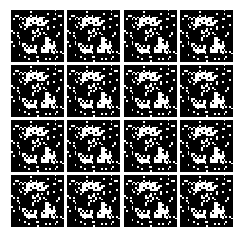


Epoch: 548
Epoch: 549


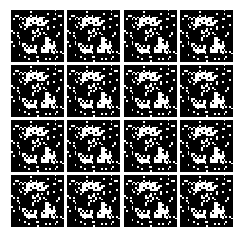


Epoch: 550
Epoch: 551


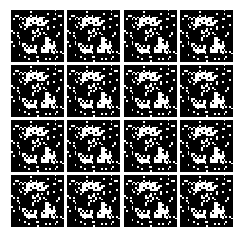


Epoch: 552
Epoch: 553


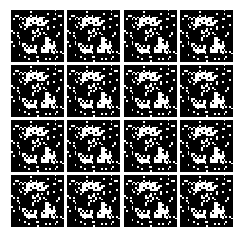


Epoch: 554
Epoch: 555


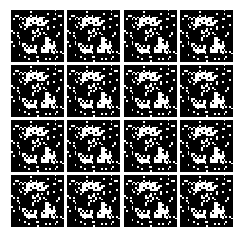


Epoch: 556
Epoch: 557


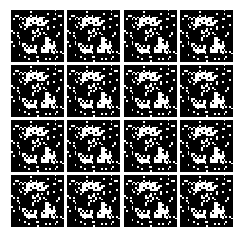


Epoch: 558
Epoch: 559


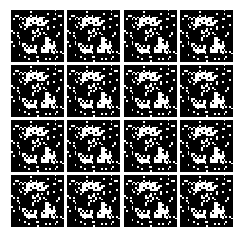


Epoch: 560
Epoch: 561


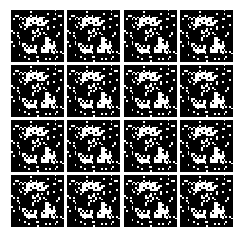


Epoch: 562
Epoch: 563


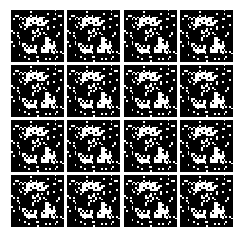


Epoch: 564
Epoch: 565


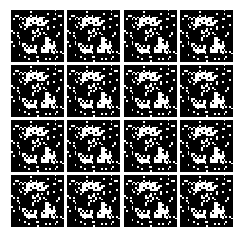


Epoch: 566
Epoch: 567


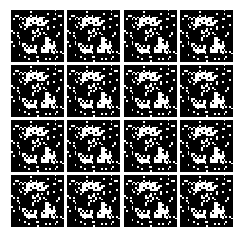


Epoch: 568
Epoch: 569


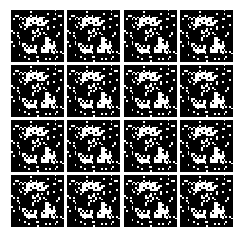


Epoch: 570
Epoch: 571


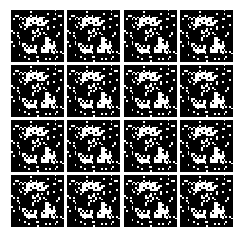


Epoch: 572
Epoch: 573


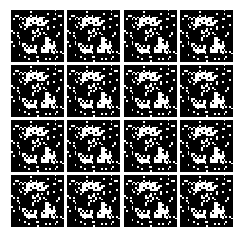


Epoch: 574
Epoch: 575


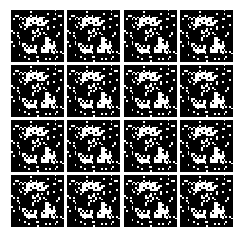


Epoch: 576
Epoch: 577


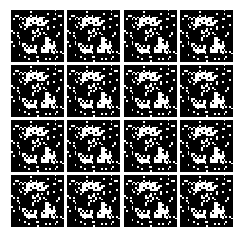


Epoch: 578
Epoch: 579


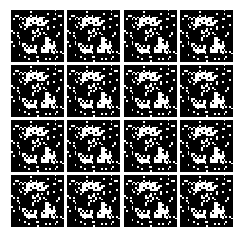


Epoch: 580
Epoch: 581


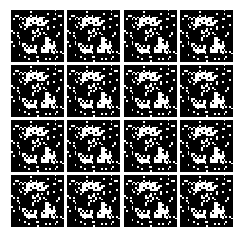


Epoch: 582
Epoch: 583


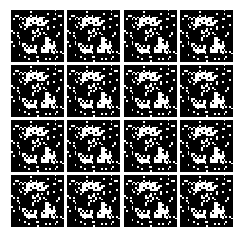


Epoch: 584
Epoch: 585


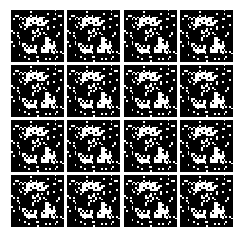


Epoch: 586
Epoch: 587


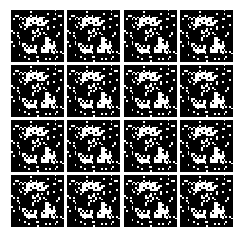


Epoch: 588
Epoch: 589


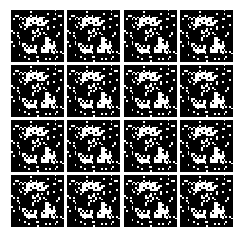


Epoch: 590
Epoch: 591


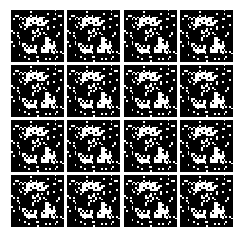


Epoch: 592
Epoch: 593


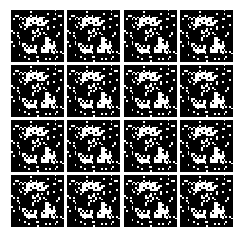


Epoch: 594
Epoch: 595


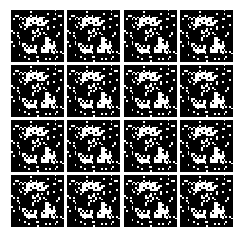


Epoch: 596
Epoch: 597


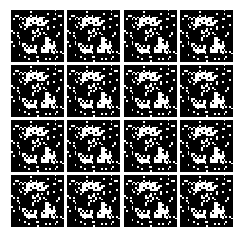


Epoch: 598
Epoch: 599


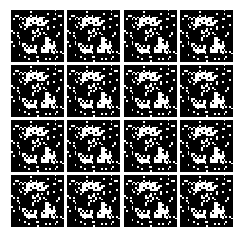


Epoch: 600
Epoch: 601


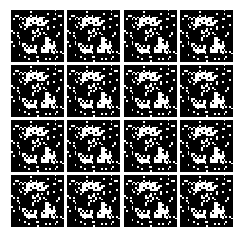


Epoch: 602
Epoch: 603


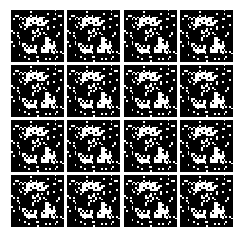


Epoch: 604
Epoch: 605


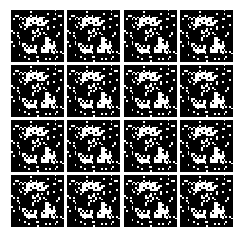


Epoch: 606
Epoch: 607


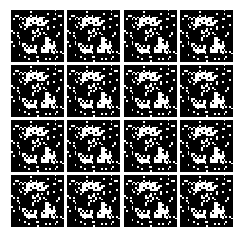


Epoch: 608
Epoch: 609


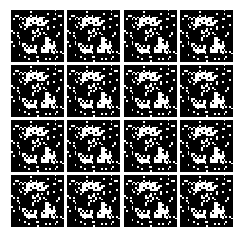


Epoch: 610
Epoch: 611


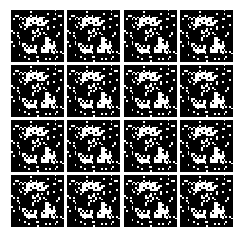


Epoch: 612
Epoch: 613


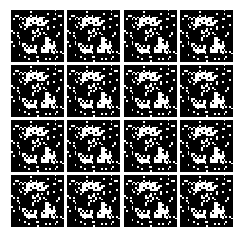


Epoch: 614
Epoch: 615


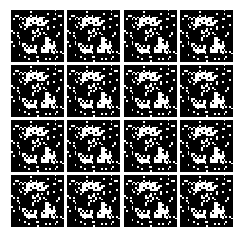


Epoch: 616
Epoch: 617


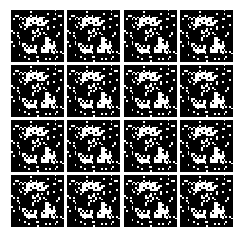


Epoch: 618
Epoch: 619


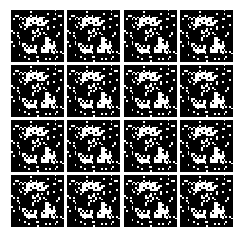


Epoch: 620
Epoch: 621


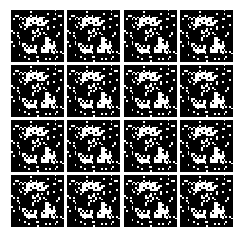


Epoch: 622
Epoch: 623


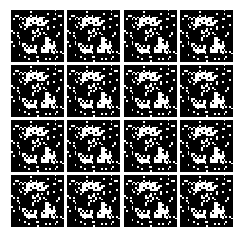


Epoch: 624
Epoch: 625


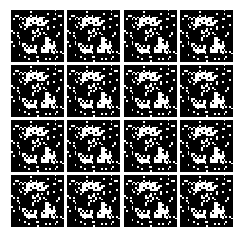


Epoch: 626
Epoch: 627


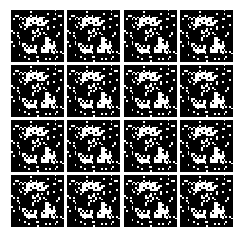


Epoch: 628
Epoch: 629


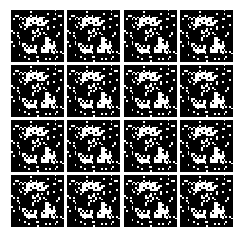


Epoch: 630
Epoch: 631


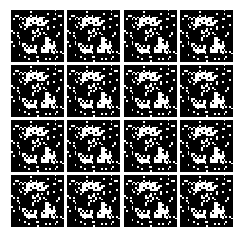


Epoch: 632
Epoch: 633


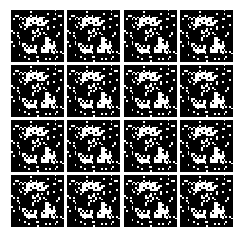


Epoch: 634
Epoch: 635


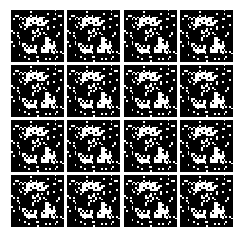


Epoch: 636
Epoch: 637


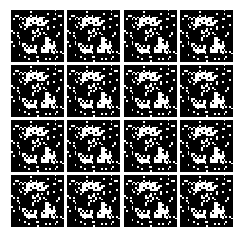


Epoch: 638
Epoch: 639


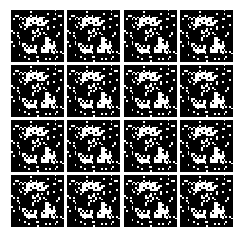


Epoch: 640
Epoch: 641


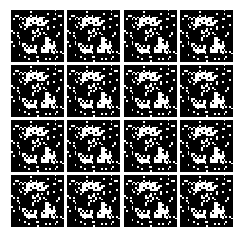


Epoch: 642
Epoch: 643


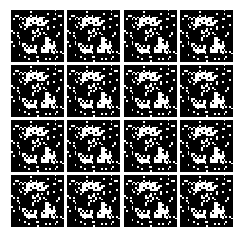


Epoch: 644
Epoch: 645


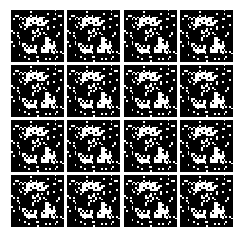


Epoch: 646
Epoch: 647


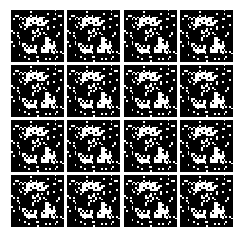


Epoch: 648
Epoch: 649


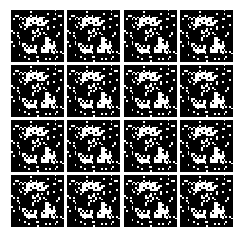


Epoch: 650
Epoch: 651


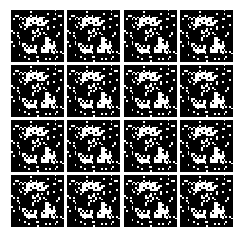


Epoch: 652
Epoch: 653


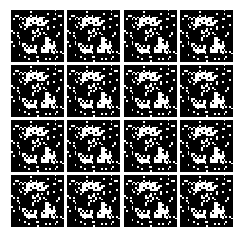


Epoch: 654
Epoch: 655


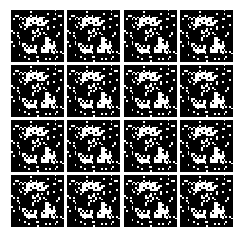


Epoch: 656
Epoch: 657


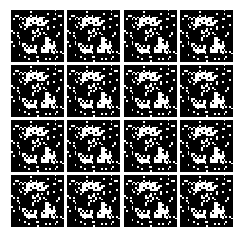


Epoch: 658
Epoch: 659


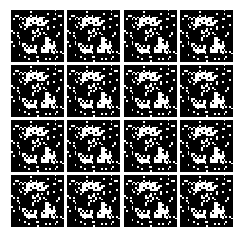


Epoch: 660
Epoch: 661


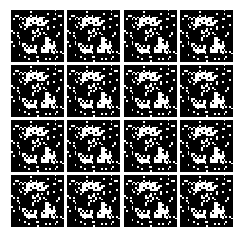


Epoch: 662
Epoch: 663


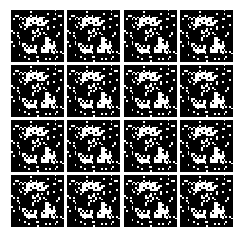


Epoch: 664
Epoch: 665


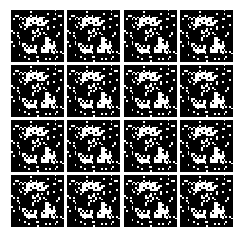


Epoch: 666
Epoch: 667


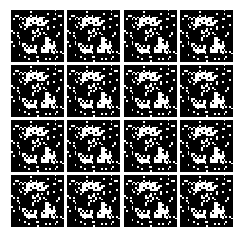


Epoch: 668
Epoch: 669


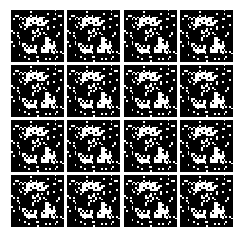


Epoch: 670
Epoch: 671


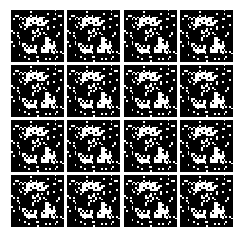


Epoch: 672
Epoch: 673


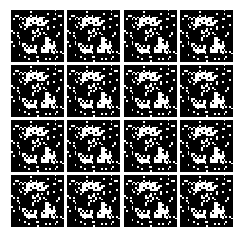


Epoch: 674
Epoch: 675


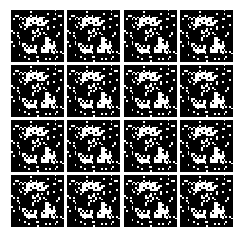


Epoch: 676
Epoch: 677


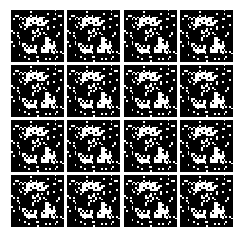


Epoch: 678
Epoch: 679


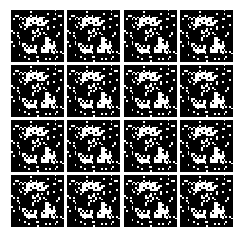


Epoch: 680
Epoch: 681


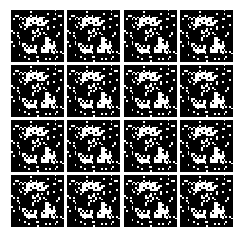


Epoch: 682
Epoch: 683


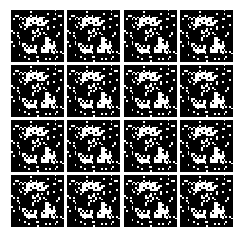


Epoch: 684
Epoch: 685


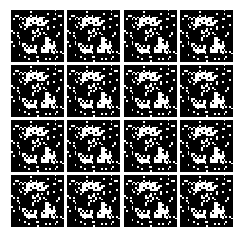


Epoch: 686
Epoch: 687


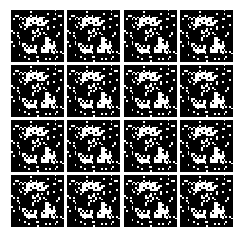


Epoch: 688
Epoch: 689


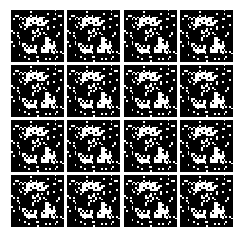


Epoch: 690
Epoch: 691


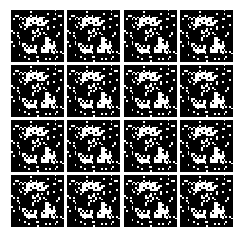


Epoch: 692
Epoch: 693


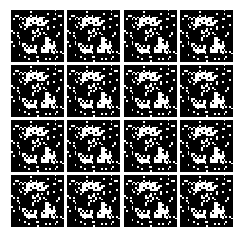


Epoch: 694
Epoch: 695


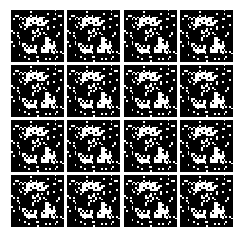


Epoch: 696
Epoch: 697


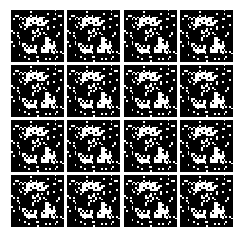


Epoch: 698
Epoch: 699


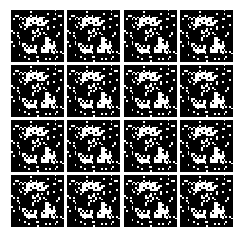


Epoch: 700
Epoch: 701


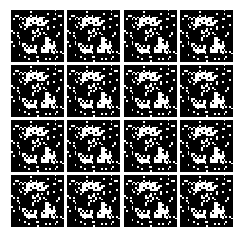


Epoch: 702
Epoch: 703


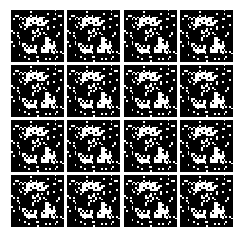


Epoch: 704
Epoch: 705


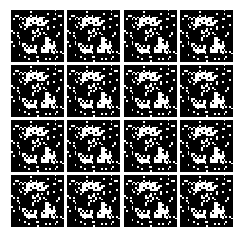


Epoch: 706
Epoch: 707


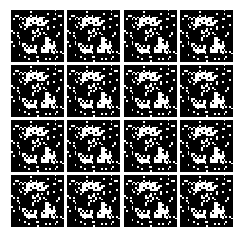


Epoch: 708
Epoch: 709


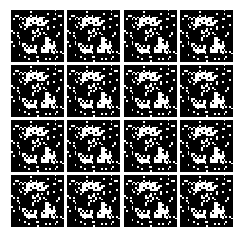


Epoch: 710
Epoch: 711


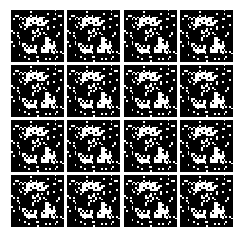


Epoch: 712
Epoch: 713


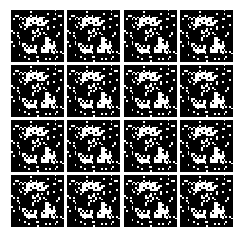


Epoch: 714
Epoch: 715


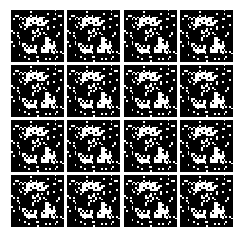


Epoch: 716
Epoch: 717


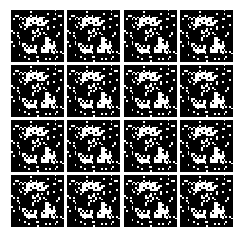


Epoch: 718
Epoch: 719


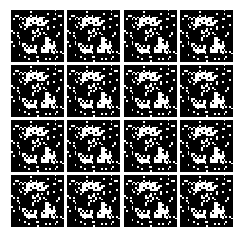


Epoch: 720
Epoch: 721


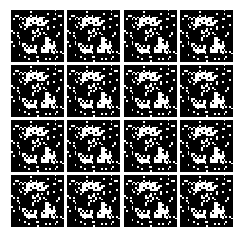


Epoch: 722
Epoch: 723


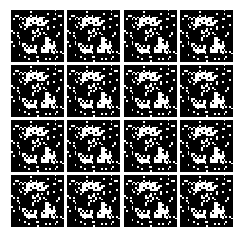


Epoch: 724
Epoch: 725


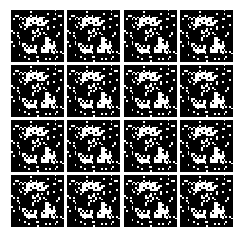


Epoch: 726
Epoch: 727


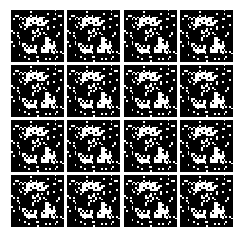


Epoch: 728
Epoch: 729


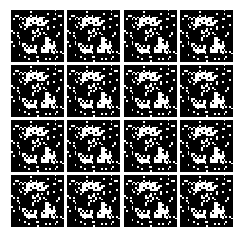


Epoch: 730
Epoch: 731


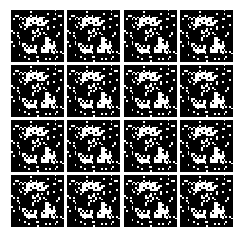


Epoch: 732
Epoch: 733


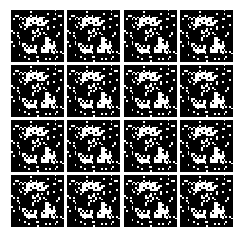


Epoch: 734
Epoch: 735


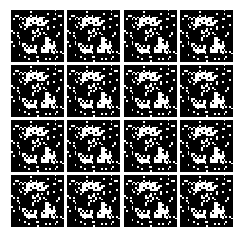


Epoch: 736
Epoch: 737


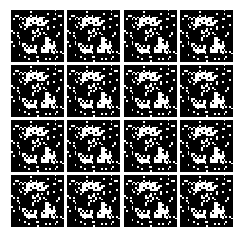


Epoch: 738
Epoch: 739


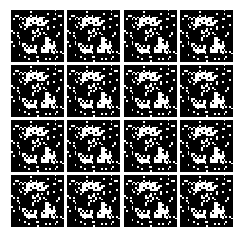


Epoch: 740
Epoch: 741


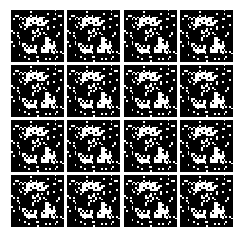


Epoch: 742
Epoch: 743


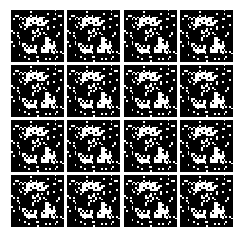


Epoch: 744
Epoch: 745


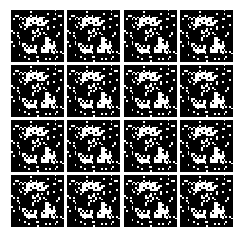


Epoch: 746
Epoch: 747


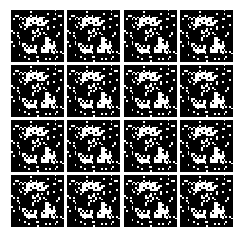


Epoch: 748
Epoch: 749


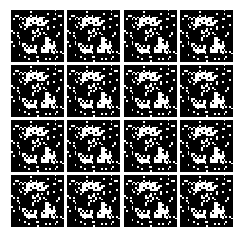


Epoch: 750
Epoch: 751


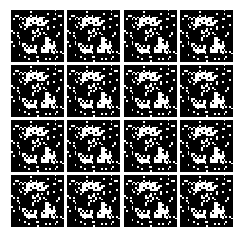


Epoch: 752
Epoch: 753


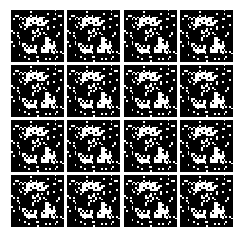


Epoch: 754
Epoch: 755


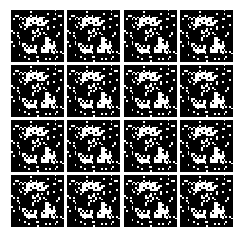


Epoch: 756
Epoch: 757


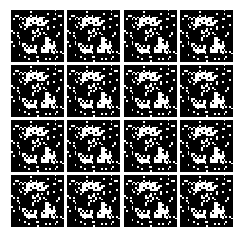


Epoch: 758
Epoch: 759


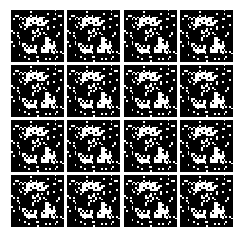


Epoch: 760
Epoch: 761


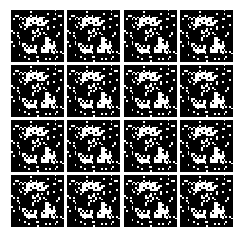


Epoch: 762
Epoch: 763


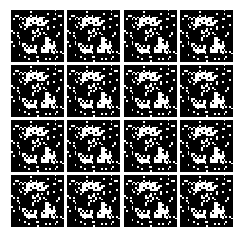


Epoch: 764
Epoch: 765


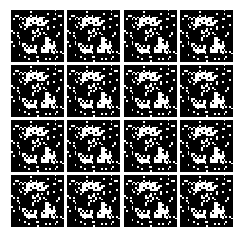


Epoch: 766
Epoch: 767


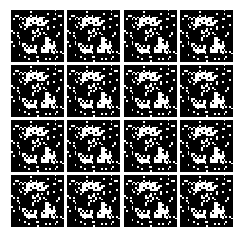


Epoch: 768
Epoch: 769


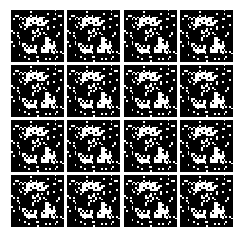


Epoch: 770
Epoch: 771


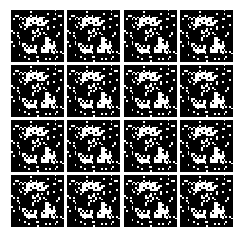


Epoch: 772
Epoch: 773


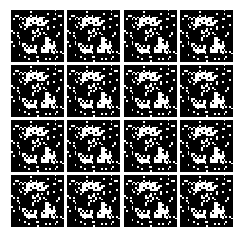


Epoch: 774
Epoch: 775


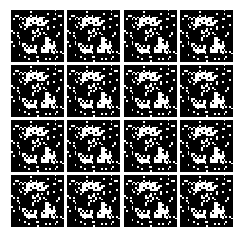


Epoch: 776
Epoch: 777


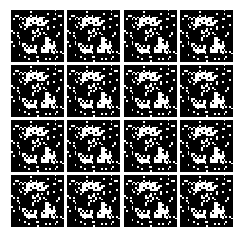


Epoch: 778
Epoch: 779


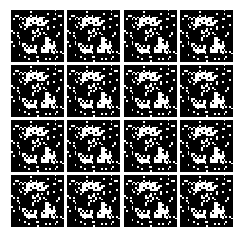


Epoch: 780
Epoch: 781


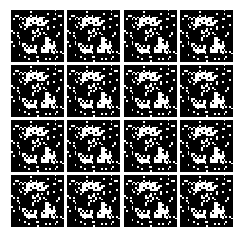


Epoch: 782
Epoch: 783


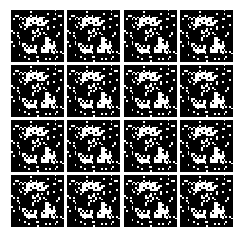


Epoch: 784
Epoch: 785


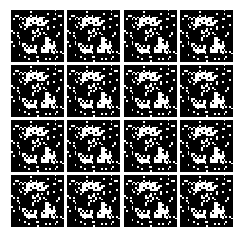


Epoch: 786
Epoch: 787


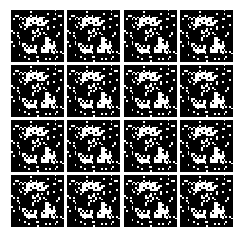


Epoch: 788
Epoch: 789


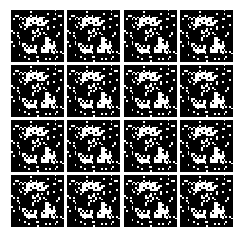


Epoch: 790
Epoch: 791


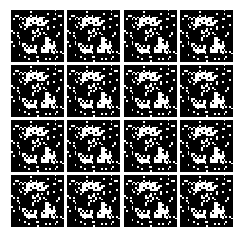


Epoch: 792
Epoch: 793


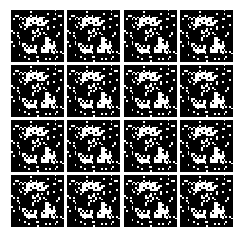


Epoch: 794
Epoch: 795


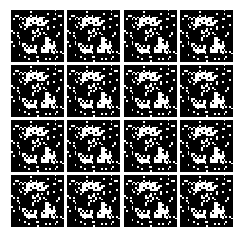


Epoch: 796
Epoch: 797


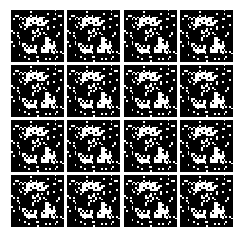


Epoch: 798
Epoch: 799


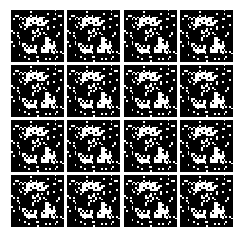


Epoch: 800
Epoch: 801


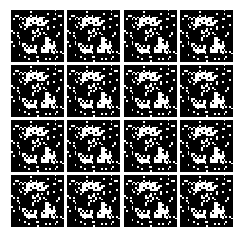


Epoch: 802
Epoch: 803


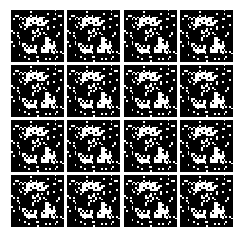


Epoch: 804
Epoch: 805


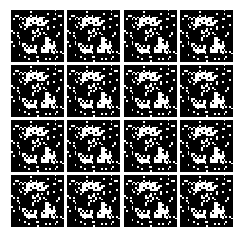


Epoch: 806
Epoch: 807


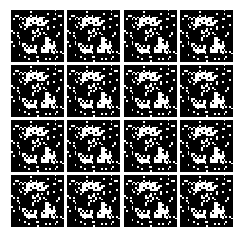


Epoch: 808
Epoch: 809


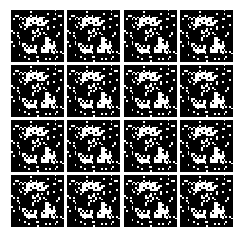


Epoch: 810
Epoch: 811


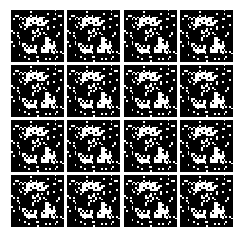


Epoch: 812
Epoch: 813


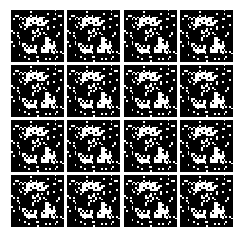


Epoch: 814
Epoch: 815


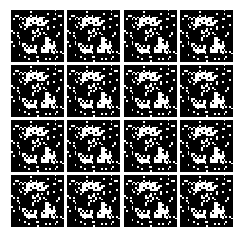


Epoch: 816
Epoch: 817


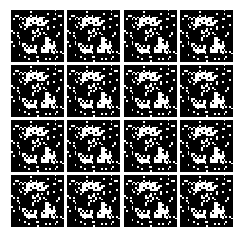


Epoch: 818
Epoch: 819


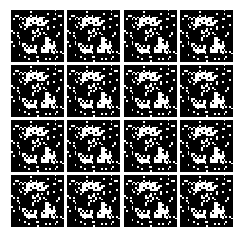


Epoch: 820
Epoch: 821


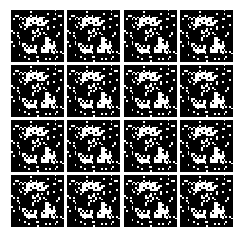


Epoch: 822
Epoch: 823


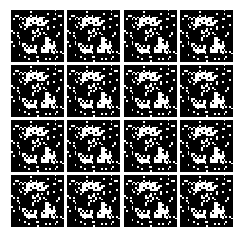


Epoch: 824
Epoch: 825


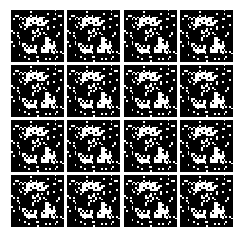


Epoch: 826
Epoch: 827


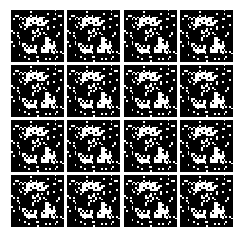


Epoch: 828
Epoch: 829


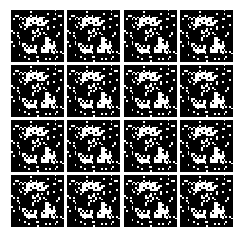


Epoch: 830
Epoch: 831


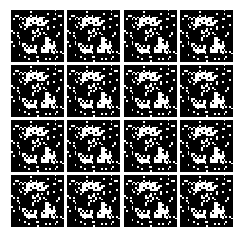


Epoch: 832
Epoch: 833


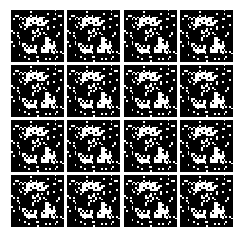


Epoch: 834
Epoch: 835


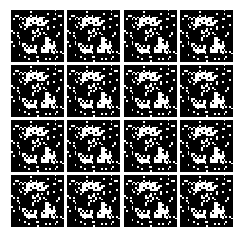


Epoch: 836
Epoch: 837


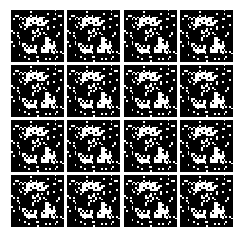


Epoch: 838
Epoch: 839


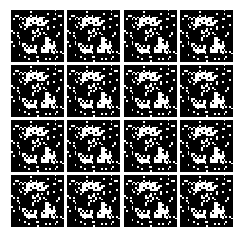


Epoch: 840
Epoch: 841


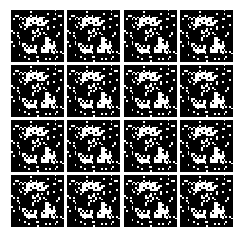


Epoch: 842
Epoch: 843


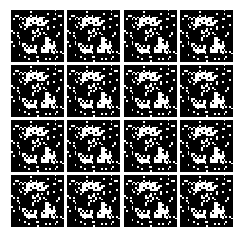


Epoch: 844
Epoch: 845


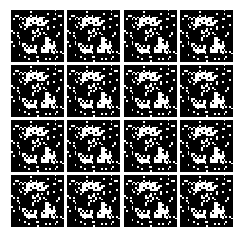


Epoch: 846
Epoch: 847


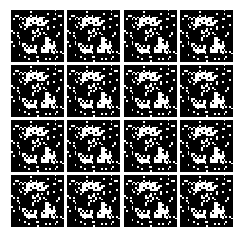


Epoch: 848
Epoch: 849


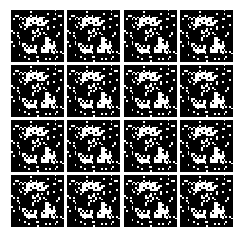


Epoch: 850
Epoch: 851


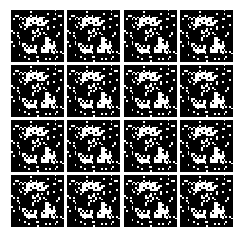


Epoch: 852
Epoch: 853


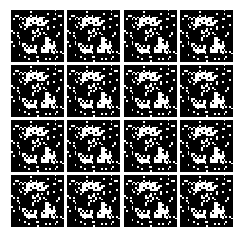


Epoch: 854
Epoch: 855


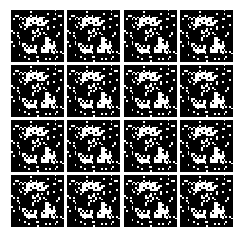


Epoch: 856
Epoch: 857


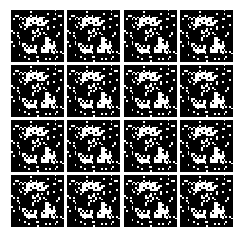


Epoch: 858
Epoch: 859


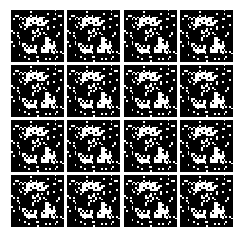


Epoch: 860
Epoch: 861


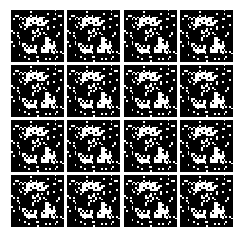


Epoch: 862
Epoch: 863


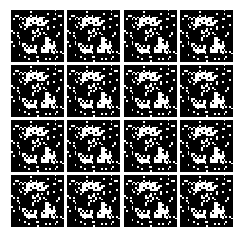


Epoch: 864
Epoch: 865


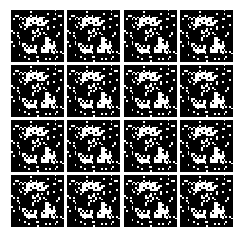


Epoch: 866
Epoch: 867


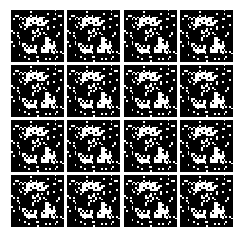


Epoch: 868
Epoch: 869


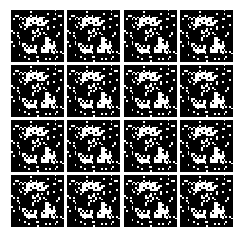


Epoch: 870
Epoch: 871


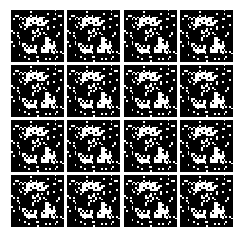


Epoch: 872
Epoch: 873


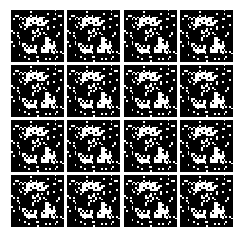


Epoch: 874
Epoch: 875


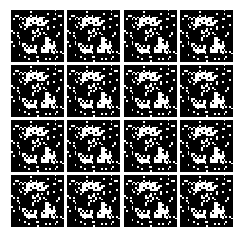


Epoch: 876
Epoch: 877


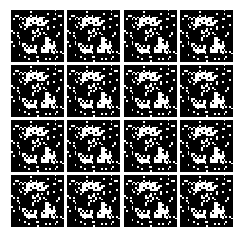


Epoch: 878
Epoch: 879


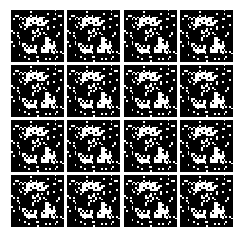


Epoch: 880
Epoch: 881


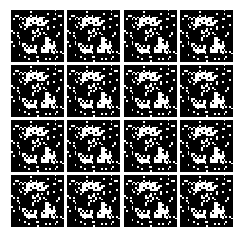


Epoch: 882
Epoch: 883


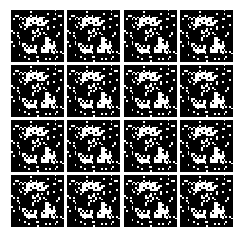


Epoch: 884
Epoch: 885


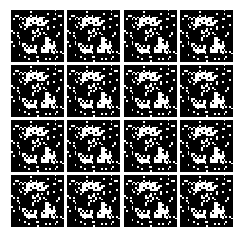


Epoch: 886
Epoch: 887


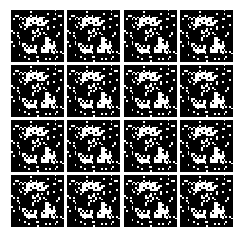


Epoch: 888
Epoch: 889


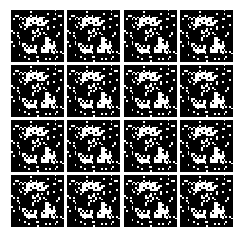


Epoch: 890
Epoch: 891


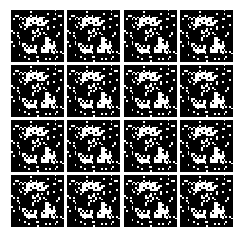


Epoch: 892
Epoch: 893


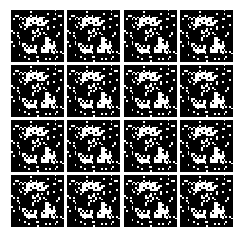


Epoch: 894
Epoch: 895


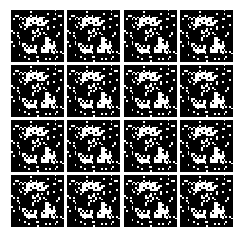


Epoch: 896
Epoch: 897


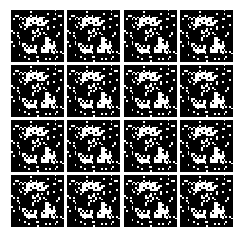


Epoch: 898
Epoch: 899


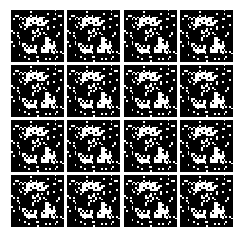


Epoch: 900
Epoch: 901


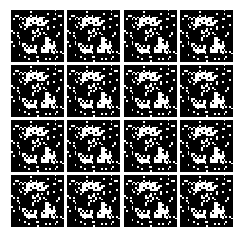


Epoch: 902
Epoch: 903


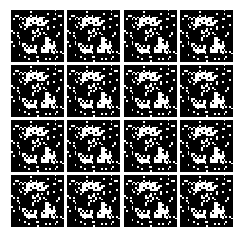


Epoch: 904
Epoch: 905


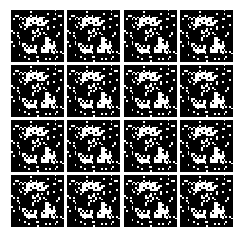


Epoch: 906
Epoch: 907


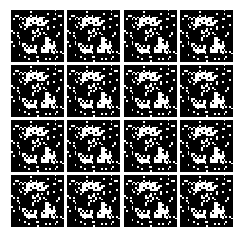


Epoch: 908
Epoch: 909


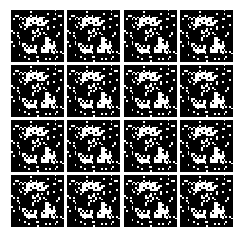


Epoch: 910
Epoch: 911


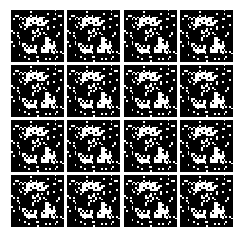


Epoch: 912
Epoch: 913


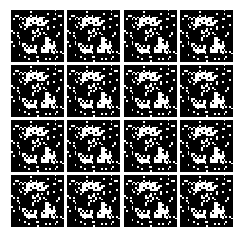


Epoch: 914
Epoch: 915


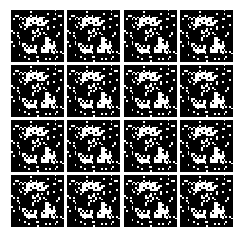


Epoch: 916
Epoch: 917


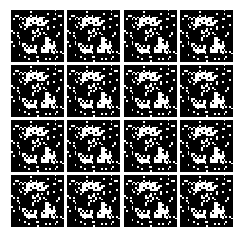


Epoch: 918
Epoch: 919


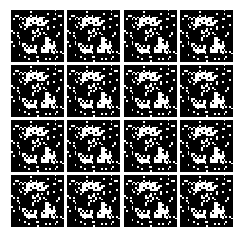


Epoch: 920
Epoch: 921


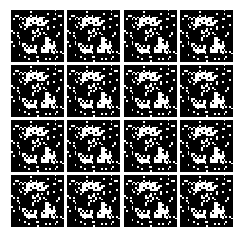


Epoch: 922
Epoch: 923


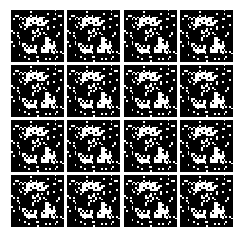


Epoch: 924
Epoch: 925


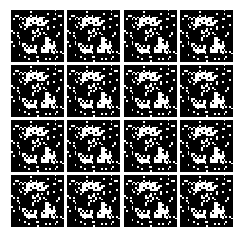


Epoch: 926
Epoch: 927


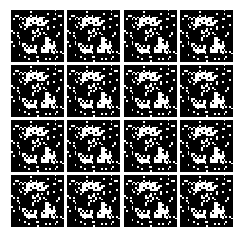


Epoch: 928
Epoch: 929


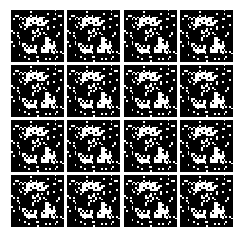


Epoch: 930
Epoch: 931


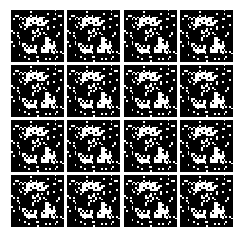


Epoch: 932
Epoch: 933


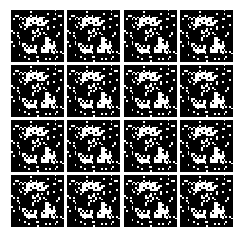


Epoch: 934
Epoch: 935


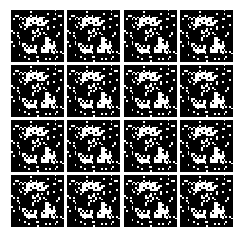


Epoch: 936
Epoch: 937


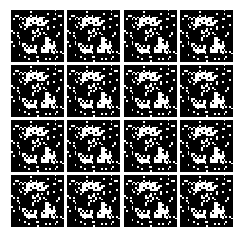


Epoch: 938
Epoch: 939


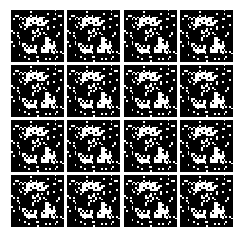


Epoch: 940
Epoch: 941


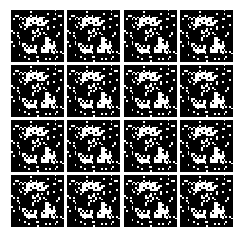


Epoch: 942
Epoch: 943


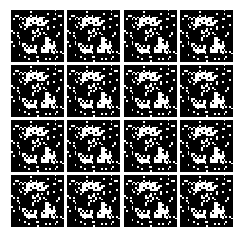


Epoch: 944
Epoch: 945


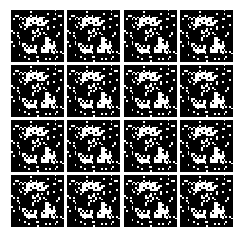


Epoch: 946
Epoch: 947


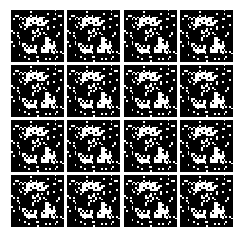


Epoch: 948
Epoch: 949


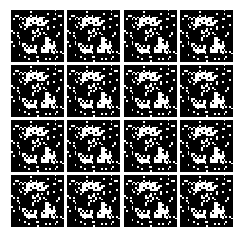


Epoch: 950
Epoch: 951


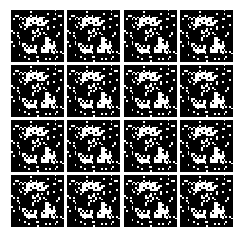


Epoch: 952
Epoch: 953


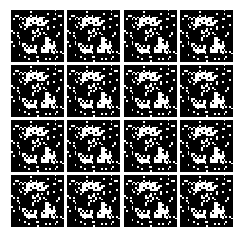


Epoch: 954
Epoch: 955


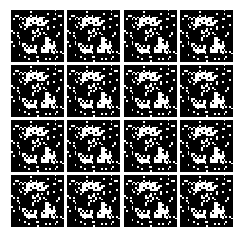


Epoch: 956
Epoch: 957


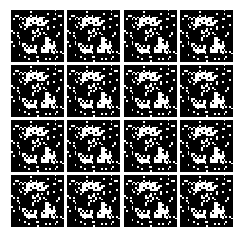


Epoch: 958
Epoch: 959


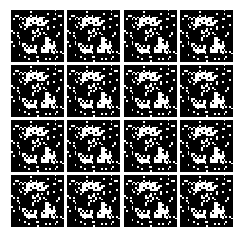


Epoch: 960
Epoch: 961


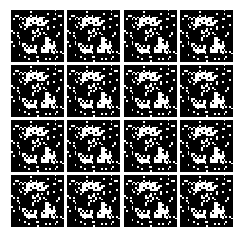


Epoch: 962
Epoch: 963


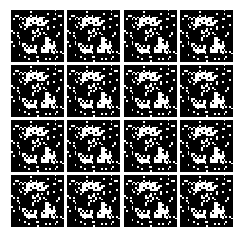


Epoch: 964
Epoch: 965


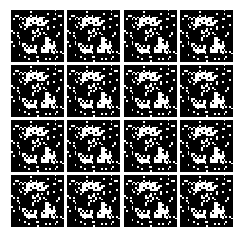


Epoch: 966
Epoch: 967


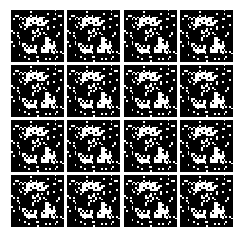


Epoch: 968
Epoch: 969


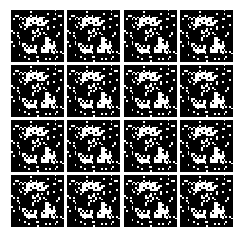


Epoch: 970
Epoch: 971


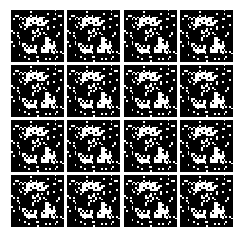


Epoch: 972
Epoch: 973


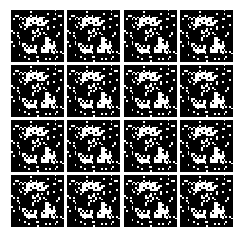


Epoch: 974
Epoch: 975


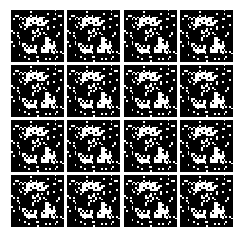


Epoch: 976
Epoch: 977


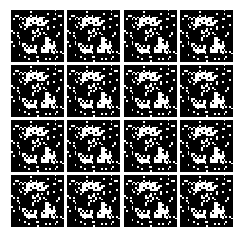


Epoch: 978
Epoch: 979


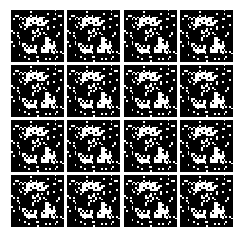


Epoch: 980
Epoch: 981


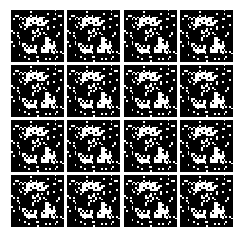


Epoch: 982
Epoch: 983


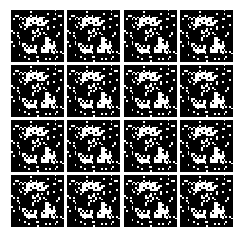


Epoch: 984
Epoch: 985


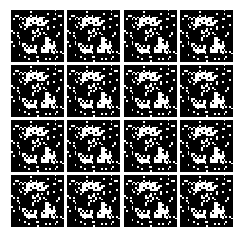


Epoch: 986
Epoch: 987


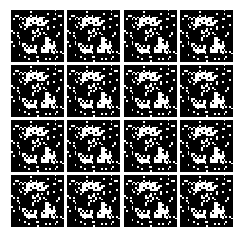


Epoch: 988
Epoch: 989


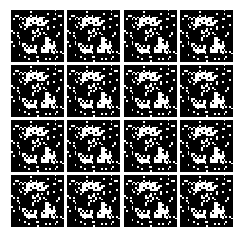


Epoch: 990
Epoch: 991


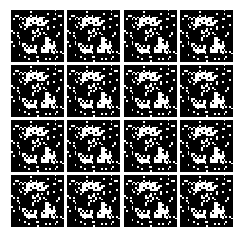


Epoch: 992
Epoch: 993


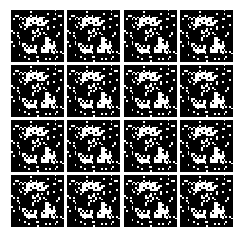


Epoch: 994
Epoch: 995


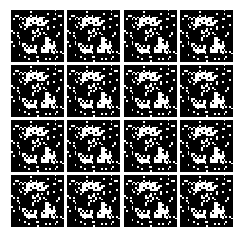


Epoch: 996
Epoch: 997


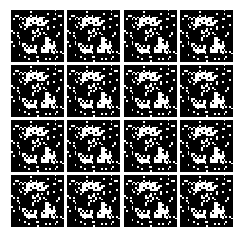


Epoch: 998
Epoch: 999
Final images


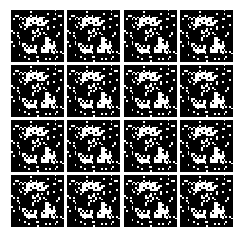

In [386]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [388]:
def lsgan_loss(scores_real, scores_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - scores_real: Tensor, shape [batch_size, 1], output of discriminator
        The score for each real image
    - scores_fake: Tensor, shape[batch_size, 1], output of discriminator
        The score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = 0.5*tf.reduce_mean((scores_real-1)**2)+0.5*tf.reduce_mean(scores_fake**2)
    G_loss = 0.5*tf.reduce_mean((scores_fake-1)**2)
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [390]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [391]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

_Run the following cell to train your model!_

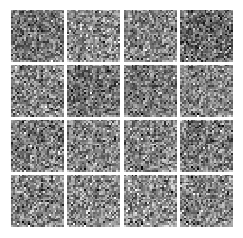


Epoch: 0
Epoch: 1


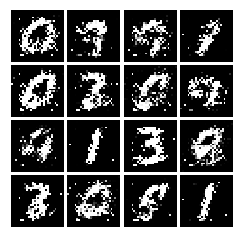


Epoch: 2
Epoch: 3


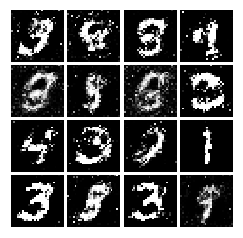


Epoch: 4
Epoch: 5


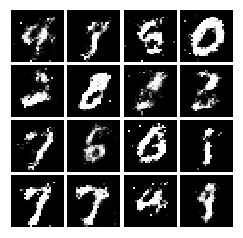


Epoch: 6
Epoch: 7


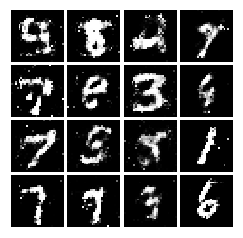


Epoch: 8
Epoch: 9


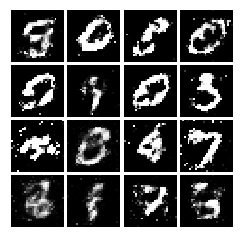


Epoch: 10
Epoch: 11


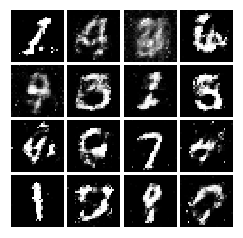


Epoch: 12
Epoch: 13


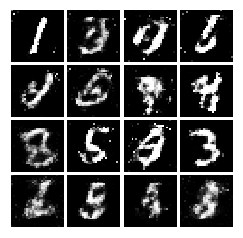


Epoch: 14
Epoch: 15


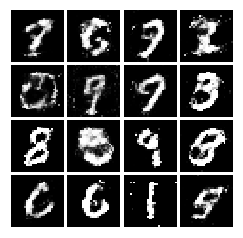


Epoch: 16
Epoch: 17


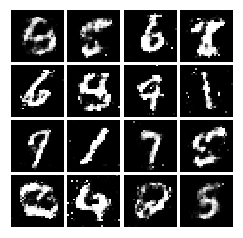


Epoch: 18
Epoch: 19


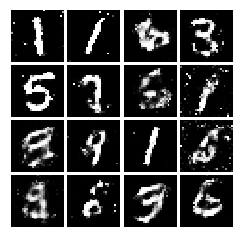


Epoch: 20
Epoch: 21


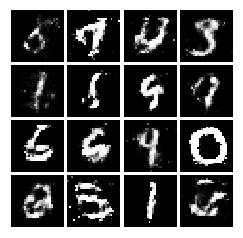


Epoch: 22


KeyboardInterrupt: 

In [392]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)
    

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [413]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x,shape=[-1,28,28,1]) #NHWC
        
        logits = tf.layers.conv2d(inputs=x,filters=32, kernel_size=[5,5],strides=1,padding='VALID',activation=None,use_bias=True)
        logits = leaky_relu(logits,alpha=0.01) 
        logits = tf.layers.max_pooling2d(inputs=logits,pool_size=[2,2],strides=2)
 
        logits = tf.layers.conv2d(inputs=logits,filters=64, kernel_size=[5,5],strides=1,padding='VALID',activation=None,use_bias=True)
        logits = leaky_relu(logits,alpha=0.01) 
        logits = tf.layers.max_pooling2d(inputs=logits,pool_size=[2,2],strides=2)
        
        logits = tf.layers.flatten(logits)
        logits = tf.layers.dense(inputs=logits,units=4*4*64,use_bias=True)
        logits = leaky_relu(logits,alpha=0.01)
        logits = tf.layers.dense(inputs=logits,units=1,use_bias=True)
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.layers` for your implementation. You might find the documentation for [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [416]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        img = tf.layers.dense(inputs=z,units=1024,use_bias=True,activation=tf.nn.relu)
        img = tf.layers.batch_normalization(inputs=img,training=True)
        
        img = tf.layers.dense(inputs=img,units=7*7*128,use_bias=True,activation=tf.nn.relu)
        img = tf.layers.batch_normalization(inputs=img,training=True)
                   
        img = tf.reshape(img, shape=[-1,7,7,128])
        
        img = tf.layers.conv2d_transpose(inputs=img, filters=64,kernel_size=[4,4],strides=2,use_bias=True,padding='same',activation=tf.nn.relu)
        img = tf.layers.batch_normalization(inputs=img,training=True)
        img = tf.layers.conv2d_transpose(inputs=img, filters=1,kernel_size=[4,4],strides=2,use_bias=True,padding='same',activation=tf.nn.tanh)
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [418]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

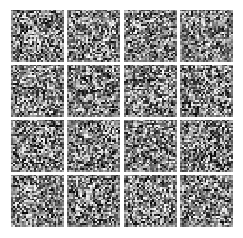

KeyboardInterrupt: 

In [419]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=100)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x) with step size $1$. 
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |       |       |       |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |       |       |       |       |       |       
   

## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:

## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient

### Your answer: